In [58]:
color_line_1 = 'royalblue'
color_line_2 = 'red'
color_scatter_1 = 'black' #'darkslategrey' #darkred
filled_color_1 = 'lightslategrey' #'lightcoral'

text_color_1 = 'royalblue'
text_color_2 = 'red'

style_theme = 'whitegrid'

# Cubic Hermitian Spline

In [1]:
import torch

def compute_cubic_spline(parameters: torch.Tensor, step: int, horizon: int):
    """ Given a set of spline parameters, and the point in the trajectory return the function value 
    
    Args :
        parameters (Tensor): Spline action parameter      of shape(batch, num_legs, 3, spline_param)              
        step          (int): The point in the curve in [0, horizon]
        horizon       (int): The length of the curve
        
    Returns : 
        actions    (Tensor): Discrete action              of shape(batch, num_legs, 3)
    """
    # Find the point in the curve q in [0,1]
    tau = step/(horizon)        
    q = (tau - 0.0)/(1.0-0.0)
    
    # Compute the spline interpolation parameters
    a =  2*q*q*q - 3*q*q     + 1
    b =    q*q*q - 2*q*q + q
    c = -2*q*q*q + 3*q*q
    d =    q*q*q -   q*q

    # Compute intermediary parameters 
    phi_1 = 0.5*(parameters[...,2]  - parameters[...,0]) # shape (batch, num_legs, 3)
    phi_2 = 0.5*(parameters[...,3]  - parameters[...,1]) # shape (batch, num_legs, 3)

    # Compute the spline
    actions = a*parameters[...,1] + b*phi_1 + c*parameters[...,2]  + d*phi_2 # shape (batch, num_legs, 3)

    return actions

In [3]:
import torch
import matplotlib.pyplot as plt

start = 0
stop = 4
steps=100

parameters = torch.tensor((0.2, 1.0, 1.0, 0.3, 1.3, 0.9, 1.5))

x_param = torch.arange(start=start-1, end=stop+2)
# print(x_param)

x = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(x)

spline = torch.empty_like(x)

for i in range(start,stop):
    # print('\nRange ',i)
    for j in range(steps):
        # print('step  ', steps*i + j)
        spline[steps*i + j] = compute_cubic_spline(parameters=parameters[i:i+4], step=j, horizon=steps)


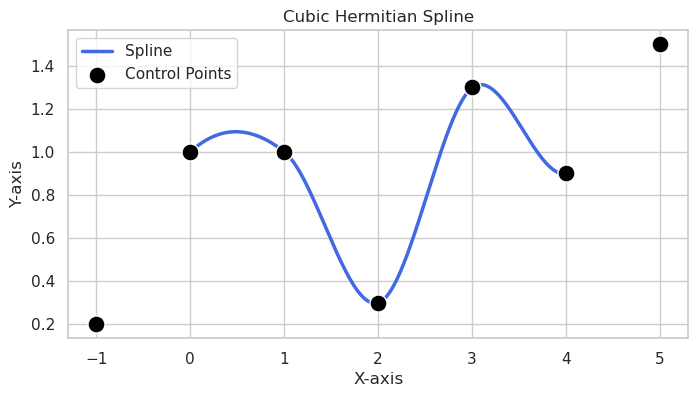

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=spline, ax=ax, color=color_line_1, linewidth=2.5, label='Spline')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_param, y=parameters, ax=ax, color=color_scatter_1, s=150, label='Control Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Hermitian Spline", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_hermite_spline.pdf", bbox_inches='tight')
plt.show()


# Spline Fitting

In [5]:
import torch

# Example data
x_data = torch.tensor([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.9, 1.0])  # 5 data points
y_data = torch.tensor([0.3, 0.0, 0.4, 0.7, 0.8, 0.6, 0.8, 1.0])  # Example target values

# Construct the design matrix X
X = torch.stack([x_data**3, x_data**2, x_data, torch.ones_like(x_data)], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c, d = torch.linalg.solve(XtX, XtY).squeeze()

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred = cubic_function(x_pred, a, b, c, d)



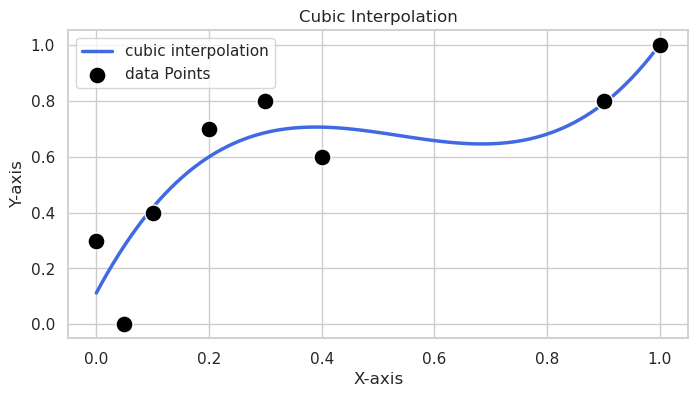

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation.pdf", bbox_inches='tight')
plt.show()


# Spline fitting with constraints

In [7]:
import torch

# Construct the design matrix X
x_data_p = x_data[1:]
y_data_p = y_data[1:] - y_data[0]


X = torch.stack([x_data_p**3, x_data_p**2, x_data_p], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data_p.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c = torch.linalg.solve(XtX, XtY).squeeze()
d = y_data[0]

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred_constraint = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred_constraint = cubic_function(x_pred_constraint, a, b, c, d)



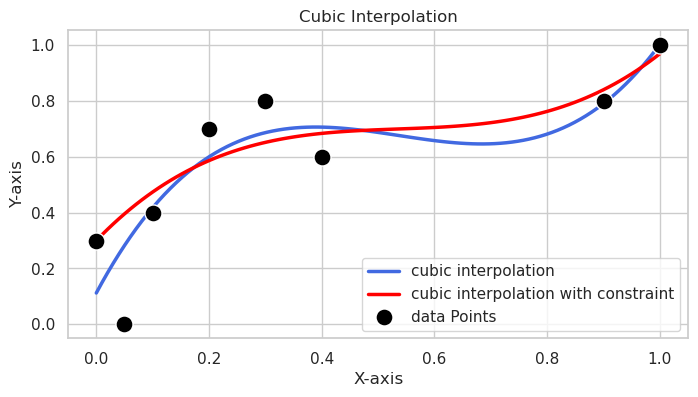

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred_constraint, y=y_pred_constraint, ax=ax, color=color_line_2, linewidth=2.5, label='cubic interpolation with constraint')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation_with_constaint.pdf", bbox_inches='tight')
plt.show()


# Bezier Curve

In [9]:
import torch

start = 0
stop = 1
steps=100

t = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(t)

cp0 = torch.tensor((0.0, 0.0))
cp1 = torch.tensor((0.2, 1.0))
cp2 = torch.tensor((1.8, 1.0))
cp3 = torch.tensor((2.0, 0.0))


def bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return cp0*((1-t)**3) + 3*cp1*t*((1-t)**2) + 3*cp2*(t**2)*(1-t) + cp3*(t**3)

x = bezier_curve_deg_3(t, cp0[0], cp1[0], cp2[0], cp3[0])
y = bezier_curve_deg_3(t, cp0[1], cp1[1], cp2[1], cp3[1])


tensor([0.0000, 0.2000, 1.8000, 2.0000])
tensor([0., 1., 1., 0.])


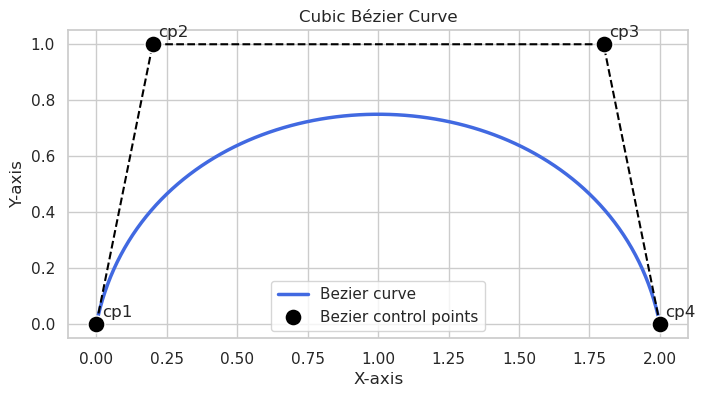

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=y, ax=ax, color=color_line_1, linewidth=2.5, label='Bezier curve')

sns.lineplot(x=torch.stack((cp0[0], cp1[0]+0.0001, cp2[0]-0.0001, cp3[0])), y=torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])), ax=ax, color=color_scatter_1, linestyle='--')

# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])), y=torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)

# Annotate the control points
control_points = ['cp1', 'cp2', 'cp3', 'cp4']
for i, (x_val, y_val) in enumerate(zip([cp0[0], cp1[0], cp2[0], cp3[0]], [cp0[1], cp1[1], cp2[1], cp3[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(15,5), ha='center')

print(torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])))
print(torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])))

# Add titles and labels
ax.set_title("Cubic Bézier Curve", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/simple_bezier_curve.pdf", bbox_inches='tight')
plt.show()


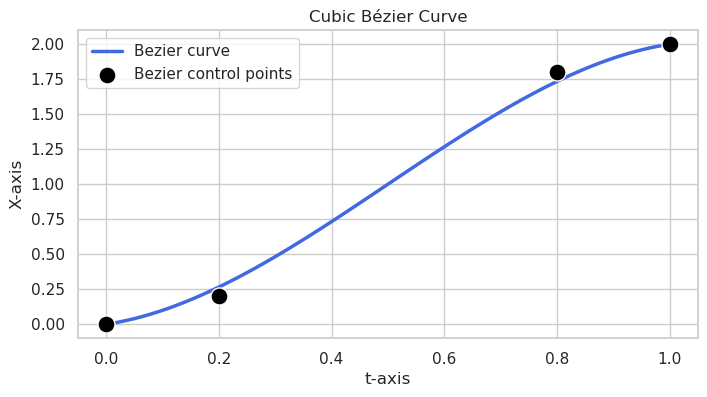

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=t, y=x, ax=ax, color=color_line_1, linewidth=2.5, label='Bezier curve')


# Add a dot plot on top of the spline
sns.scatterplot(x=torch.tensor((0.0, 0.2, 0.8 ,1.0)) ,y=torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)


# Add titles and labels
ax.set_title("Cubic Bézier Curve", fontsize=12)
ax.set_xlabel("t-axis", fontsize=12)
ax.set_ylabel("X-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
# plt.savefig("thesis image/B/simple_bezier_curve.pdf", bbox_inches='tight')
plt.show()


# Swing Trajectory

## Swing trajectory Position

In [49]:
import torch

start = 0
stop = 1
steps=100

t = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(t)

p0 = torch.tensor((0.0, 0.0, 0.05))
p1 = torch.tensor((0.1, 0.1, 0.25))
p2 = torch.tensor((0.2, 0.2, 0.15))

# # Point for the swing traj plot
# # p0 = torch.tensor((0.0, 0.0, 0.00))
# # p1 = torch.tensor((0.1, 0.1, 0.10))
# # p2 = torch.tensor((0.2, 0.2, 0.0))
# p0 = torch.tensor((0.00, 0.00, 0.00))
# p1 = torch.tensor((0.05, 0.05, 0.10))
# p2 = torch.tensor((0.10, 0.10, 0.0))

# Normal CP
cp0_1 = torch.tensor((p0[0], p0[1], p0[2]))
cp1_1 = torch.tensor((p0[0], p0[1], p0[2]))
cp2_1 = torch.tensor((p0[0], p0[1], p1[2]))
cp3_1 = torch.tensor((p1[0], p1[1], p1[2]))

cp0_2 = torch.tensor((p1[0], p1[1], p1[2]))
cp1_2 = torch.tensor((p2[0], p2[1], p1[2]))
cp2_2 = torch.tensor((p2[0], p2[1], p2[2]))
cp3_2 = torch.tensor((p2[0], p2[1], p2[2]))

# Bat test
# cp0_1 = torch.tensor((p0[0], p0[1], p0[2]))
# cp1_1 = torch.tensor((p1[0], p1[1], p0[2]))
# cp2_1 = torch.tensor((p1[0], p1[1], p1[2]))
# cp3_1 = torch.tensor((p1[0], p1[1], p1[2]))

# cp0_2 = torch.tensor((p1[0], p1[1], p1[2]))
# cp1_2 = torch.tensor((p2[0], p2[1], p1[2]))
# cp2_2 = torch.tensor((p2[0], p2[1], p2[2]))
# cp3_2 = torch.tensor((p2[0], p2[1], p2[2]))


def bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return cp0*((1-t)**3) + 3*cp1*t*((1-t)**2) + 3*cp2*(t**2)*(1-t) + cp3*(t**3)

def dot_bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return 3*(cp1 - cp0)*((1 - t)**2) + 6*(cp2 - cp1)*(1 - t)*(t) + 3*(cp3 - cp2)*(t**2)

def dot_dot_bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return 6*(1 - t)*(cp2 - 2*cp1 + cp0) + 6*t*(cp3 - 2*cp2 + cp1)

x_1 = bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_1 = bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_1 = bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_2 = bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_2 = bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_2 = bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])


x_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])

x_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])

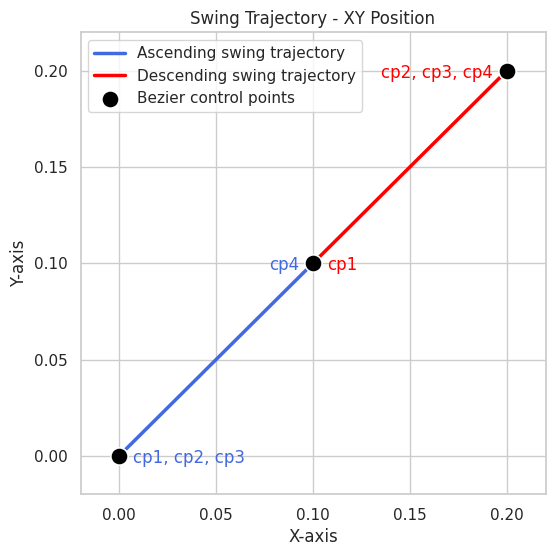

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_1, y=y_1, ax=ax, color=color_line_1, linewidth=2.5, label='Ascending swing trajectory')
sns.lineplot(x=x_2, y=y_2, ax=ax, color=color_line_2, linewidth=2.5, label='Descending swing trajectory')

# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])), y=torch.stack((cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)
sns.scatterplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])), y=torch.stack((cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])), ax=ax, color=color_scatter_1, s=150, zorder=5)


# Annotate the control points
control_points = ['cp1, cp2, cp3']
for i, (x_val, y_val) in enumerate(zip([cp0_1[0]], [cp0_1[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-5), color=text_color_1)
control_points = ['cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_1[0]], [cp3_1[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-5), ha='right', color=text_color_1)
control_points = ['cp1']
for i, (x_val, y_val) in enumerate(zip([cp0_2[0]], [cp0_2[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-5), ha='left', color=text_color_2)
control_points = ['cp2, cp3, cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_2[0]], [cp3_2[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-5), ha='right', color=text_color_2)

# Add titles and labels
ax.set_title("Swing Trajectory - XY Position", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

ax.set_xlim(-0.02, 0.22)
ax.set_ylim(-0.02, 0.22)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xy_bezier_curve.pdf", bbox_inches='tight')
plt.show()


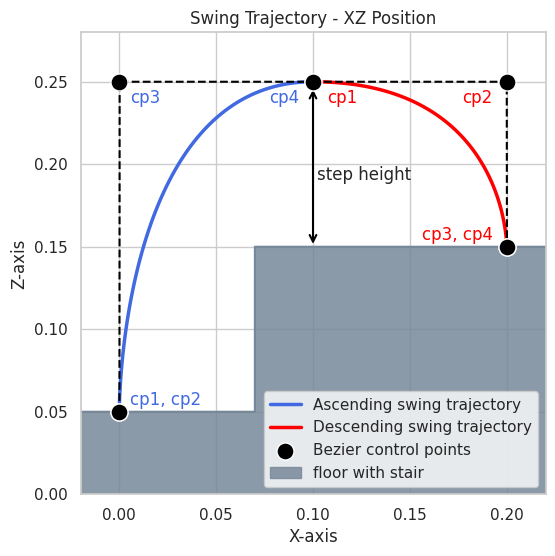

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_1, y=z_1, ax=ax, color=color_line_1, linewidth=2.5, label='Ascending swing trajectory')
sns.lineplot(x=x_2, y=z_2, ax=ax, color=color_line_2, linewidth=2.5, label='Descending swing trajectory')

sns.lineplot(x=torch.stack((cp0_1[0], cp1_1[0]+0.0001, cp2_1[0]+0.0002, cp3_1[0])), y=torch.stack((cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])), ax=ax, color=color_scatter_1, linestyle='--')
sns.lineplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0]+0.0001, cp3_2[0]+0.0001)), y=torch.stack((cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])), ax=ax, color=color_scatter_1, linestyle='--')


# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])), y=torch.stack((cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)
sns.scatterplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])), y=torch.stack((cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])), ax=ax, color=color_scatter_1, s=150, zorder=5)

# Annotate the control points
control_points = ['cp1, cp2']
for i, (x_val, y_val) in enumerate(zip([cp0_1[0]], [cp0_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(8,5), color=text_color_1)
control_points = ['cp3']
for i, (x_val, y_val) in enumerate(zip([cp2_1[0]], [cp2_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(8,-15), color=text_color_1)
control_points = ['cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_1[0]], [cp3_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-15), ha='right', color=text_color_1)
control_points = ['cp1']
for i, (x_val, y_val) in enumerate(zip([cp0_2[0]], [cp0_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-15), ha='left', color=text_color_2)
control_points = ['cp2']
for i, (x_val, y_val) in enumerate(zip([cp1_2[0]], [cp1_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-15), ha='right', color=text_color_2)
    control_points = ['cp3, cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_2[0]], [cp3_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,5), ha='right', color=text_color_2)


# add the stair
x = torch.tensor((-1.0, 0.07, 0.07001, 1.2))
y = torch.tensor((0.05, 0.05, 0.15, 0.15))
sns.lineplot(x=x, y=y, ax=ax, color=filled_color_1)
ax.fill_between(x, y, color=filled_color_1, alpha=0.85, label='floor with stair')

#  Draw a double-sided arrow
A = (0.10, 0.15)
B = (0.10, 0.247)
ax.annotate(
    '', xy=B, xytext=A,
    arrowprops=dict(arrowstyle='<->', color='black', lw=1.5)
)
ax.text((A[0] + B[0]) / 2 + 0.002, (A[1] + B[1]) / 2 - 0.005, 'step height', fontsize=12, ha='left', va='center')


# Add titles and labels
ax.set_title("Swing Trajectory - XZ Position", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Z-axis", fontsize=12)

ax.set_xlim(-0.02, 0.22)
ax.set_ylim(0.0, 0.28)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/z_bezier_curve.pdf", bbox_inches='tight')
plt.show()


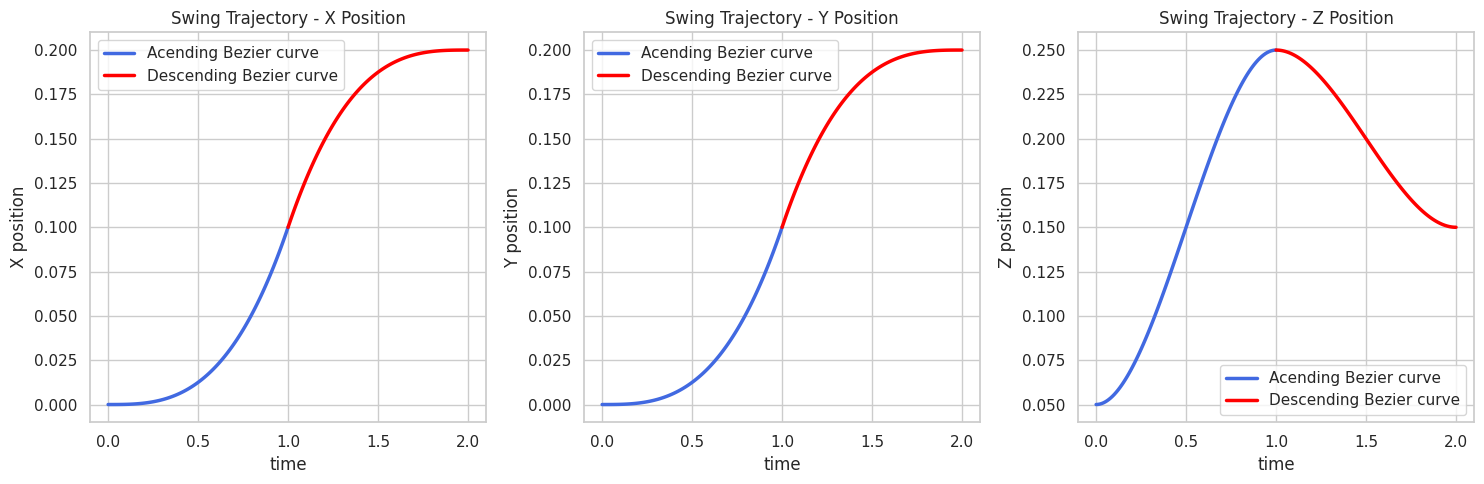

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_1, x_2, y_1, y_2, z_1, z_2 are defined
# and style_theme, color_line_1 are also defined

sns.set_theme(style=style_theme)

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

label_1 = 'Acending Bezier curve'
label_2 = 'Descending Bezier curve'

# Plot x position on the first subplot
sns.lineplot(x=t, y=x_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Position", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X position", fontsize=12)
axes[0].legend()

# Plot y position on the second subplot
sns.lineplot(x=t, y=y_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Position", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y position", fontsize=12)
axes[1].legend()

# Plot z position on the third subplot
sns.lineplot(x=t, y=z_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Position", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z position", fontsize=12)
axes[2].legend()#loc='lower right')

# axes[2].set_xlim(-0.1, 2.1)
# axes[2].set_ylim(0.0, 0.28)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_position_bezier_curve.pdf", bbox_inches='tight')
plt.show()


## Swing traj 3D plot for report

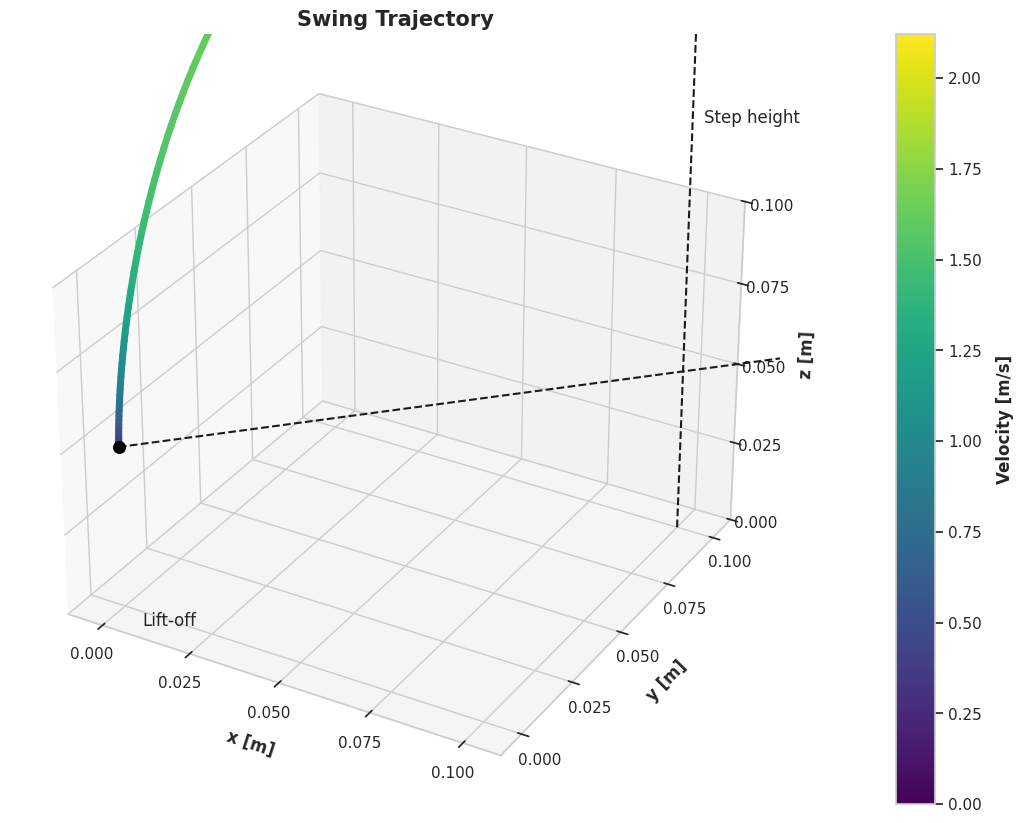

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Sample data (use your actual data here)
# p_x, p_y, p_z, v_x, v_y, v_z = np.array([...]), np.array([...]), np.array([...]), np.array([...]), np.array([...]), np.array([...])

p_x = np.concatenate([x_1,x_2])
p_y = np.concatenate([y_1,y_2])
p_z = np.concatenate([z_1,z_2])

v_x = np.concatenate([x_dot_1,x_dot_2])*5
v_y = np.concatenate([y_dot_1,y_dot_2])*5
v_z = np.concatenate([z_dot_1,z_dot_2])*5

# Compute the norm of the velocity
velocity_norm = np.sqrt((v_x**2) + (v_y**2) + (v_z**2))

# Normalize the velocity norm for color mapping
norm = plt.Normalize(velocity_norm.min(), velocity_norm.max())

# Create a color map
cmap = plt.cm.viridis

# Create a 3D plot
sns.set_style(style="whitegrid")

# Create a figure and a 3D axis
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
for i in range(len(p_x)-1):
    ax.plot(p_x[i:i+2], p_y[i:i+2], p_z[i:i+2], color=cmap(norm(velocity_norm[i])), linewidth=5)


# Label specific points
ax.scatter(p_x[0], p_y[0], p_z[0], s=70, label='Lift-off' , color='black')
ax.scatter(p_x[-1], p_y[-1], p_z[-1], s=70, label='Touch down', color='black')

middle_index = len(p_x) // 2
# ax.scatter(p_x[middle_index], p_y[middle_index], p_z[middle_index], color='black', s=100, label='Step height')
# ax.text(p_x[middle_index], p_y[middle_index], p_z[middle_index], ' Step height', color='blue')

# Label the midpoint of the dashed line
midpoint_x = p_x[middle_index]
midpoint_y = p_y[middle_index]
midpoint_z = (0 + p_z[middle_index]) / 2
offset = 0.002  # Adjust as needed
ax.text(midpoint_x + offset, midpoint_y + offset, midpoint_z, 'Step height')#, color='blue', fontsize=12)


# Dashed line between lift-off and touch down in the XY plane
ax.plot([p_x[0], p_x[-1]], [p_y[0], p_y[-1]], [p_z[0], p_z[0]], 'k--')

# Dashed line between step height in the XY plane and step height point
ax.plot([p_x[middle_index], p_x[middle_index]], [p_y[middle_index], p_y[middle_index]], [0, p_z[middle_index]], 'k--')


# Create a color bar
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(velocity_norm)
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)



# Set the labels on the XY plane and adjust their positions
ax.text(p_x[0]+0.005, p_y[0], 0, 'Lift-off',fontsize=12, ha='left', va='top') #color='red', 
ax.text(p_x[-1]-0.005, p_y[-1], 0, 'Touch down', fontsize=12, ha='right', va='bottom') # color='red', 




# Add color bar for reference
# fig.colorbar(surf, shrink=0.5, aspect=5)

# Add titles and labels
ax.set_title('Swing Trajectory', fontsize=15, fontweight='bold')
ax.set_xlabel('x [m]', fontsize=12, labelpad=10, fontweight='bold')#, fontweight='bold')
ax.set_ylabel('y [m]', fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel('z [m]', fontsize=12, labelpad=10, fontweight='bold')
cbar.set_label('Velocity [m/s]', fontsize=12, labelpad=10, fontweight='bold')



min_x, max_x = 0.00, 0.10
min_y, max_y = 0.00, 0.10
min_z, max_z = 0.00, 0.10
ax.set_xlim(min_x-0.01, max_x+0.01)
ax.set_ylim(min_y-0.01, max_y+0.01)
ax.set_zlim(min_z, max_z)
# Customize tick intervals
ax.set_xticks(np.linspace(min_x, max_x, 5))
ax.set_yticks(np.linspace(min_y, max_y, 5))
ax.set_zticks(np.linspace(min_z, max_z, 5))
# ax.grid(True, linestyle='--', color='gray', linewidth=0.5)

plt.savefig("thesis image/4.5/swing_traj.pdf", bbox_inches='tight')

# Show plot
plt.show()


## Swing Trajectory Velocity

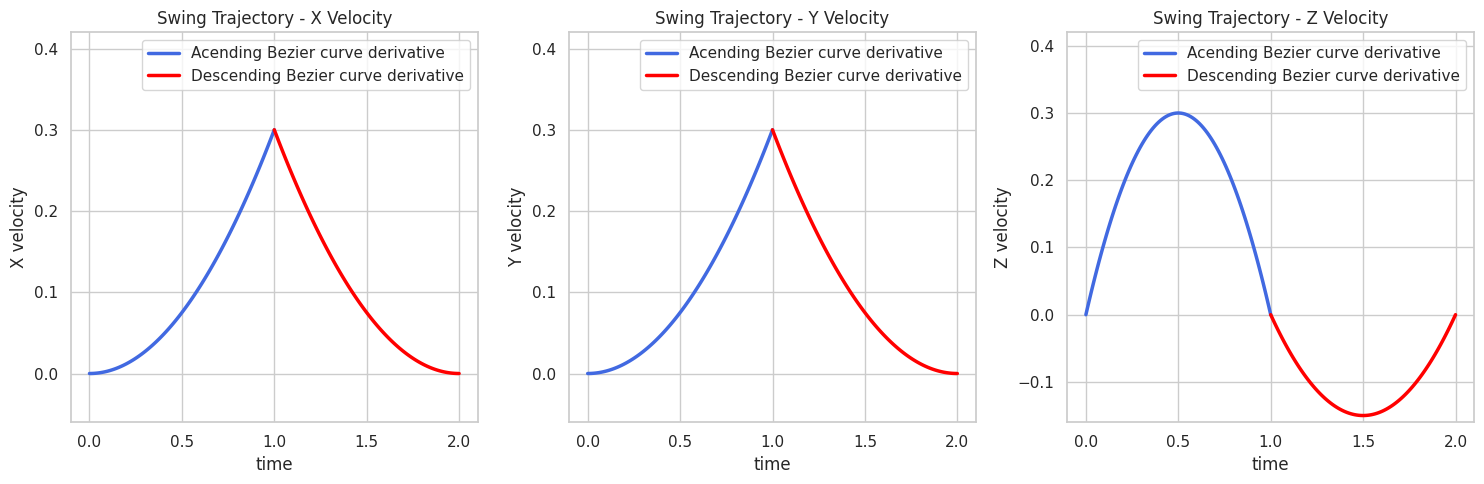

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_dot_1, x_dot_2, y_dot_1, y_dot_2, z_dot_1, z_dot_2 are defined
# and style_theme, color_line_1, and color_line_2 are also defined

sns.set_theme(style=style_theme)

label_1 = 'Acending Bezier curve derivative'
label_2 = 'Descending Bezier curve derivative'

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot x velocity on the first subplot
sns.lineplot(x=t, y=x_dot_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_dot_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Velocity", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X velocity", fontsize=12)
# axes[0].legend()
axes[0].set_ylim(-0.06, 0.42)

# Plot y velocity on the second subplot
sns.lineplot(x=t, y=y_dot_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_dot_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Velocity", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y velocity", fontsize=12)
axes[1].legend()
axes[1].set_ylim(-0.06, 0.42)

# Plot z velocity on the third subplot
sns.lineplot(x=t, y=z_dot_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_dot_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Velocity", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z velocity", fontsize=12)
axes[2].legend()

axes[2].set_ylim(-0.16, 0.42)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_dot_bezier_curve.pdf", bbox_inches='tight')
plt.show()


## Swing trajectory Acceleration

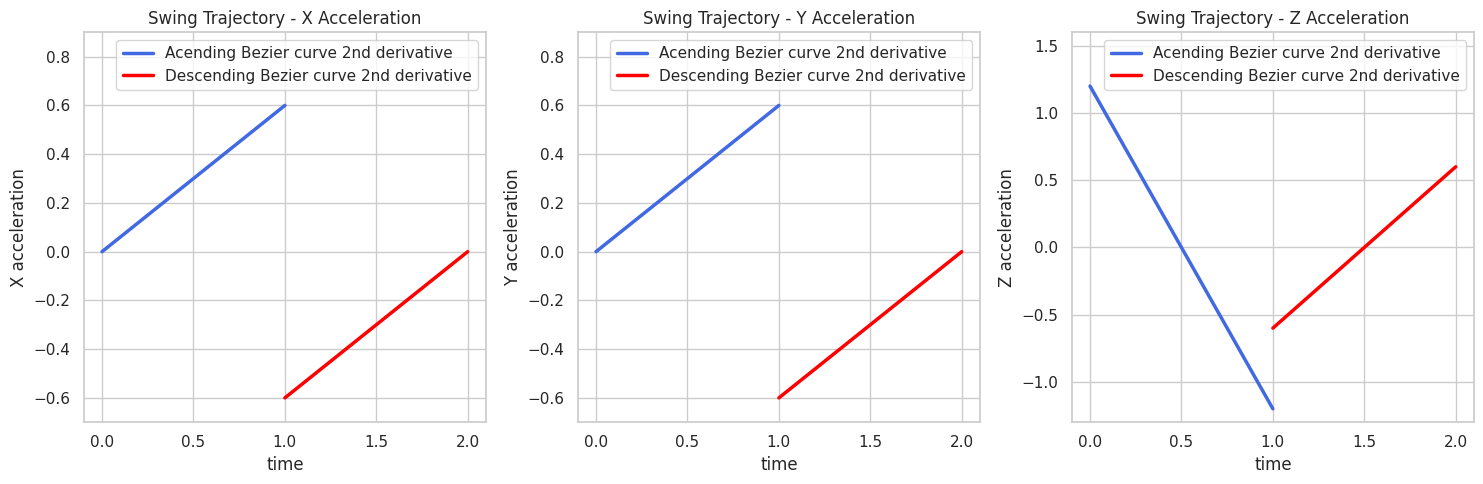

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_dot_dot_1, x_dot_dot_2, y_dot_dot_1, y_dot_dot_2, z_dot_dot_1, z_dot_dot_2 are defined
# and style_theme, color_line_1, and color_line_2 are also defined
sns.set_theme(style=style_theme)
# sns.set_context("paper")

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

label_1 = 'Acending Bezier curve 2nd derivative'
label_2 = 'Descending Bezier curve 2nd derivative'

# Plot x acceleration on the first subplot
sns.lineplot(x=t, y=x_dot_dot_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_dot_dot_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Acceleration", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X acceleration", fontsize=12)
axes[0].legend(loc='upper right')
axes[0].set_ylim(-0.7, 0.9)

# Plot y acceleration on the second subplot
sns.lineplot(x=t, y=y_dot_dot_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_dot_dot_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Acceleration", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y acceleration", fontsize=12)
axes[1].legend(loc='upper right')
axes[1].set_ylim(-0.7, 0.9)

# Plot z acceleration on the third subplot
sns.lineplot(x=t, y=z_dot_dot_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_dot_dot_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Acceleration", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z acceleration", fontsize=12)
axes[2].legend(loc='upper right')
axes[2].set_ylim(-1.3, 1.6)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_dot_dot_bezier_curve.pdf", bbox_inches='tight')
plt.show()


# Soft Exp Kernel

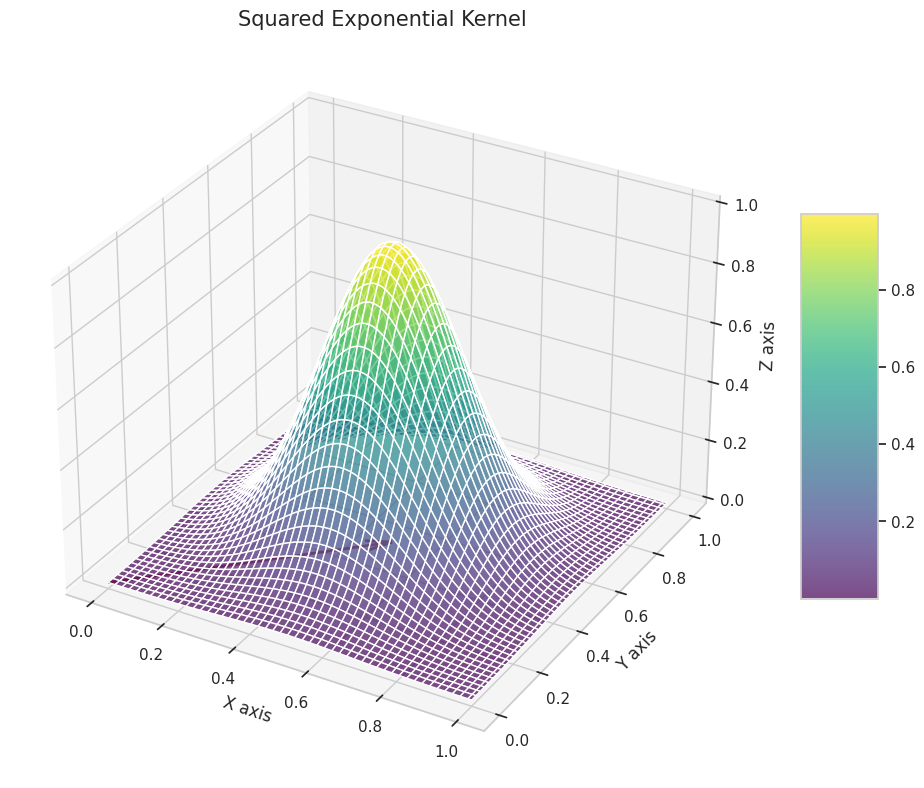

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set the Seaborn style
sns.set_theme(style="whitegrid")

v = np.array([0.5,0.5])
std = 0.25

# Define the function f(x, y)
def f(x, y):
    lin_err = (v[0] - x)**2 + (v[1] - y)**2
    return np.exp(-lin_err/(std**2))
    # return np.sin(np.sqrt(x**2 + y**2))

# Create a grid of x, y values
x = np.linspace(0.0, 1, 100)
y = np.linspace(0.0, 1, 100)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with transparency
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.7)#,  zorder=1)  # alpha controls transparency

# Add color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=5)

# Draw the arrow in the xy-plane
ax.quiver(0, 0, 0, v[0], v[1], 0, color='r', arrow_length_ratio=0.1,  linewidth=2, zorder=40)

x_line = [0.5, 0.5]
y_line = [0.5, 0.5]
z_line = [0.0, 1.0]
# ax.plot(x_line, y_line, z_line, linestyle='--', color='r',  linewidth=2, zorder=30)

# ax.scatter(0.5, 0.5, 1.0, s=50, color='r', zorder=31, label='Scatter point')

# Add titles and labels
ax.set_title('Squared Exponential Kernel', fontsize=15)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

plt.savefig("thesis image/D/squared_exponential.pdf", bbox_inches='tight')

# Show the plot
plt.show()


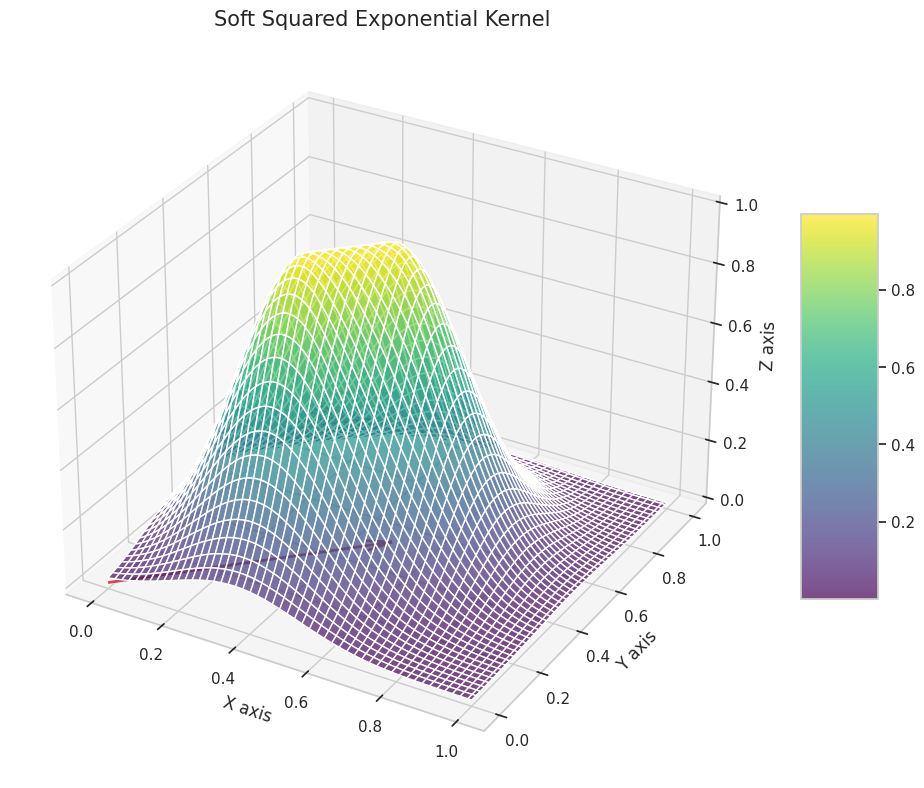

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set the Seaborn style
sns.set_theme(style="whitegrid")


v = np.array([0.5,0.5])
std = 0.25
alpha=0.2

# Define the function f(x, y)
def f(vx, vy):

    v_ref_norm = ((v[0]**2) + (v[1]**2))**(0.5)

    forward_error = -v_ref_norm + ((v[0]*vx + v[1]*vy)/(v_ref_norm))
    lateral_error = -(v[1]*vx - v[0]*vy)/(v_ref_norm)

    x_sup_0 = forward_error >= 0.0
    # x_in_0_alpha = (forward_error >= -alpha) and (forward_error <= 0)
    x_inf_alpha = forward_error < -alpha

    h_forward_error = 0.0 + (forward_error*x_sup_0) + ((forward_error + alpha)*x_inf_alpha) #+ (0 * x_in_0_alpha) 
    # h_forward_error = forward_error

    return np.exp(-((h_forward_error**2) + (lateral_error**2))/(std**2))
    # return np.sin(np.sqrt(x**2 + y**2))

# Create a grid of x, y values
x = np.linspace(0.0, 1, 100)
y = np.linspace(0.0, 1, 100)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with transparency
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.7)#,  zorder=1)  # alpha controls transparency

# Add color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=5)


# Draw the arrow in the xy-plane
ax.quiver(0, 0, 0, v[0], v[1], 0, color='r', arrow_length_ratio=0.1,  linewidth=2, zorder=40)

# x_line = [0.5, 0.5]
# y_line = [0.5, 0.5]
# z_line = [0.0, 1.0]
# ax.plot(x_line, y_line, z_line, linestyle='--', color='r',  linewidth=2, zorder=30)

# ax.scatter(0.5, 0.5, 1.0, s=50, color='r', zorder=31, label='Scatter point')

# Add titles and labels
ax.set_title('Soft Squared Exponential Kernel', fontsize=15)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

plt.savefig("thesis image/D/soft_squared_exponential.pdf", bbox_inches='tight')

# Show the plot
plt.show()


# Gait Plot - Hildebrand style diagram

/tmp/ipykernel_10007/3731113867.py:73: FutureWarning: The provided callable <function nanmean at 0x757060162b90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary = df.pivot_table(index='Side', values=['TD_p', 'TO_p'],


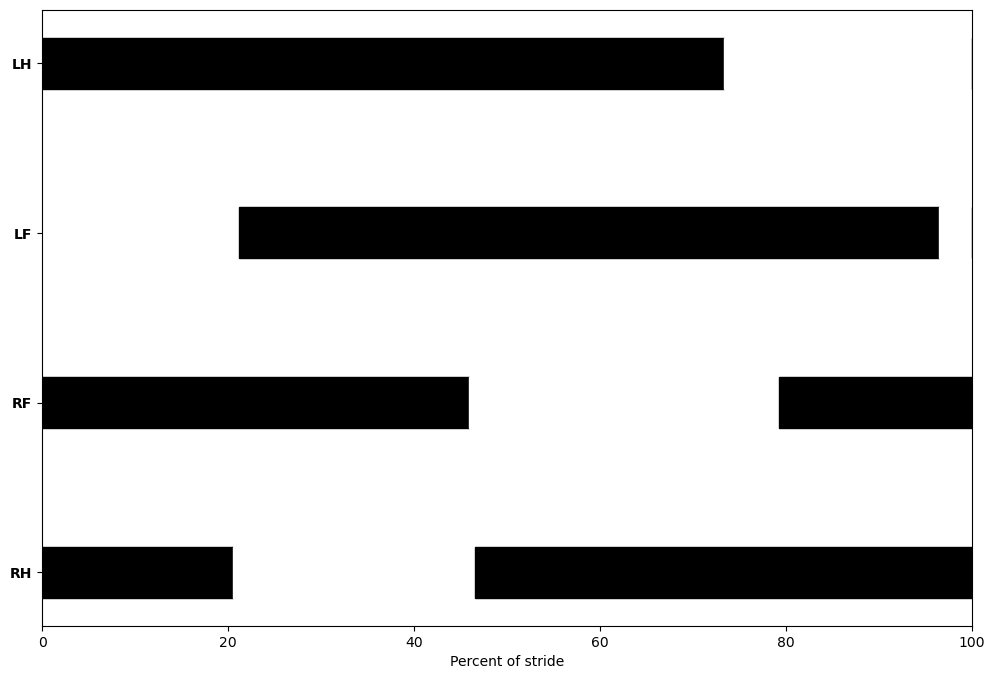

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def convert_frame(frame, start, end):
    """
    Given a frame, converts it to % of total (using reference frames for start and end of the stride; typically start
    is the first contact of the left hind foot, and end is the next contact of that same foot.
    Note that 100 and 200 were chosen for stride cycles of a tapir filmed at 240fps. You may need to expand the range
    for your data, always keeping 'out' between 0 and 100.
    You could probably programmatically subtract the correct number of hundreds but I'm lazy and this is my data.
    :param frame:
    :param start:
    :param end:
    :return:
    """
    out = (frame - start) / (end - start) * 100
    if out <= 100:
        return out
    elif out <= 200:
        return out - 100
    else:
        return out - 200


def define_plot_values(td, to):
    """
    For a stacked bar chart of white black white black, fill in the values. The structure varies because sometimes the
    strides loop after 100%; so we set up a dictionary with values for wbwb to do a stacked bar chart.
    :param td: toe-down of that foot
    :param to: toe-off of that foot
    :return:
    """
    if td == 0:  # for LH: no white, black from 0 to toe off, white from there to 100, no black
        plotvals = [0, to, 100 - to, 0]
        err_td = 0
        err_to = 1
        # error for TO goes on the b1 bar
    elif td < to:  # for when TD happens after 0 but no wrapping: white to td, black to to, white to 100, no black
        plotvals = [td, to - td, 100 - to, 0]
        err_td = 0
        err_to = 3
        # TD error goes on w2, TO error goes on b2
    else:  # when it wraps around: no white, black to TO, white between TO and TD, black to 100
        plotvals = [0, to, td - to, 100 - td]
        err_td = 2
        err_to = 1
        # TD error goes on w2, TO error goes on b1

    return plotvals, (err_td, err_to)


if __name__ == '__main__':
    df = pd.read_csv("thesis image/4.5/contact_frames.csv")

    steps = df.drop_duplicates(subset=['Trial', 'Pass', 'Step'], inplace=False).reset_index(drop=True)
    footvals = ['LH', 'LF', 'RF', 'RH']
    # For every trial, pass, and step combination:
    for i in range(len(steps.index)):
        start = steps['TD'][i]
        try:
            end = steps['TD'][i + 1]
        except KeyError:
            break
        # Rows of interest: rows corresponding to step i
        roi = df[df['Step'] == steps['Step'][i]].index
        # Convert TD and TO into % of total
        df.loc[roi, 'TD_p'] = df.iloc[roi]['TD'].apply(convert_frame, args=(start, end))
        df.loc[roi, 'TO_p'] = df.iloc[roi]['TO'].apply(convert_frame, args=(start, end))

    # Get the average and standard error of the TD and TO values for each foot
    summary = df.pivot_table(index='Side', values=['TD_p', 'TO_p'],
                             aggfunc=[np.nanmean, lambda x: np.nanstd(x)/np.sqrt(len(x))]).reindex(footvals[::-1])
    plotvals = []
    # TODO: find an easy way of setting up error values in the correct places.
    #       note that the define_plot_values function does a quick and dirty job of saying which bar the error should
    #       go on, but I think there's probably a cleaner way to do it. That's a problem for the future, and may be
    #       easier if the rest of this code is cleaned up a little too.

    # For each TD/TO pairing, calculate where the white and black bars should go
    for foot in list(zip(summary['nanmean']['TD_p'], summary['nanmean']['TO_p'])):
        err_array = [0, 0, 0, 0]
        pv, err = define_plot_values(foot[0], foot[1])
        plotvals.append(pv)

    # Transpose the data into white/black instead of td/to
    w1 = [x[0] for x in plotvals]
    b1 = [x[1] for x in plotvals]
    w2 = [x[2] for x in plotvals]
    b2 = [x[3] for x in plotvals]

    # The position of the bars on the x-axis
    r = [0, 1, 2, 3]

    df_figure = plt.figure(figsize=(12, 8))
    # With thanks to http://python-graph-gallery.com/12-stacked-barplot-with-matplotlib/
    # In order, plot the white, black, white, black
    # Note how each bar has to start at the end of the previous (with left = _)
    plt.barh(r, w1, color='white', edgecolor='white', height=0.3)
    plt.barh(r, b1, left=w1, color='black', edgecolor='black', height=0.3)  # use xerr = _ to set the errors
    plt.barh(r, w2, left=np.add(b1, w1), color='white', edgecolor='white', height=0.3)
    plt.barh(r, b2, left=np.add(np.add(b1, w1), w2), color='black', edgecolor='black', height=0.3)

    # Set the y axis accordingly
    plt.yticks(r, footvals[::-1], fontweight='bold')
    plt.xlabel("Percent of stride")

    plt.show()

    # df_figure.savefig(fname="figures/stridestride_cycle.jpg")

# Imitiation Learning Plot

## Activation Function

In [4]:
import os
import json
import torch
import pandas as pd

epochs = torch.arange(20)+1

# Specify the full path to the directory
path = "/home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64"


experiment = []
short_experiment = []
simulation_performance = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


for folder_name in os.listdir(path):
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print("Folder:", full_path)

        # Read data
        json_info_path = os.path.join(full_path, "info.json")
        json_data_path = os.path.join(full_path, "results.json")
        
        if os.path.isfile(json_info_path):
            with open(json_info_path, 'r') as json_file:
                info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", info_dict)  # You can process the dictionary as needed
        if os.path.isfile(json_data_path):
            with open(json_data_path, 'r') as json_file:
                data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", data_dict)  # You can process the dictionary as needed


        experiment_name = f"H{info_dict['prediction_horizon_step']}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(experiment_name)
        short_experiment_name = f"{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(short_experiment_name)

        sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
        # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
        print(sim_perf)

        experiment.append(experiment_name)
        short_experiment.append(short_experiment_name)
        simulation_performance.append(sim_perf)


        reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
        epoch_reward_df.loc[short_experiment_name] = reward_data

        MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
        epoch_MSE_df.loc[short_experiment_name] = MSE_data


new_order_positions = [2, 1, 0, 3, 4]
# Reorder the DataFrame rows
epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
epoch_reward_df

epoch_MSE_df


Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment25
H5-MB64-discrete-discrete-exp-0.4
exp-0.4
0.9833680214529052
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment7
H5-MB64-discrete-discrete-indicator-[0, 1, 2]
indicator-[0, 1, 2]
0.9763003034967919
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment1
H5-MB64-discrete-discrete-indicator-[0]
indicator-[0]
0.9746448563130116
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment13
H5-MB64-discrete-discrete-exp-0.6
exp-0.6
0.9853899942162242
Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - miniB64/experiment19
H5-MB64-discrete-discrete-exp-0.9
exp-0.9
0.9867173681862069

189.951213
-263.902386


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
indicator-[0],2.596963,7.762601,6.129829,3.467313,1.194602,0.586376,0.410171,0.339650,0.304857,0.290814,0.383543,0.358942,0.388972,0.358719,0.356756,0.351536,0.326256,0.321885,0.317331,0.323555
"indicator-[0, 1, 2]",1.945516,1.336838,0.970977,2.615602,2.498754,0.909124,0.517780,0.399589,0.312602,0.287560,0.320992,0.302899,0.269831,0.278956,0.275351,0.257789,0.242547,0.243089,0.239159,0.243585
exp-0.4,1.967470,2.099494,1.187902,0.617041,0.447000,0.359980,0.301820,0.275726,0.257728,0.241110,0.334787,0.278476,0.325745,0.303263,0.268885,0.275619,0.277308,0.266026,0.271411,0.264940
exp-0.6,1.729125,1.620047,0.929538,0.461015,0.336581,0.318466,0.289241,0.270877,0.249217,0.244912,0.225816,0.248108,0.231842,0.227599,0.213515,0.203798,0.220032,0.211497,0.205717,0.204834
exp-0.9,1.903169,1.446967,0.788261,0.356678,0.273574,0.257442,0.243624,0.238496,0.230484,0.225948,0.181255,0.172496,0.170718,0.166408,0.163822,0.165192,0.165396,0.163919,0.164047,0.165174


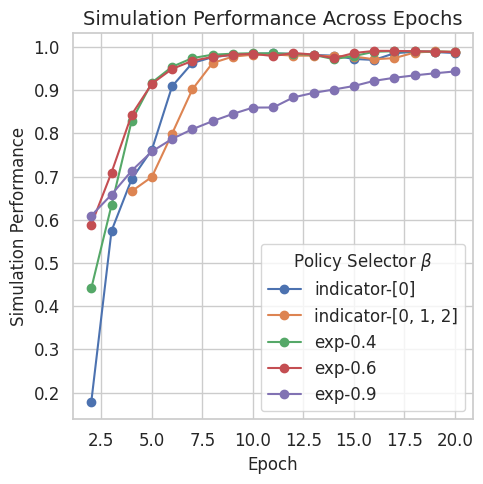

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
# plt.figure(figsize=(8, 5))
plt.figure(figsize=(5, 5))

for index, row in epoch_reward_df.iterrows():
    plt.plot(epoch_reward_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('Simulation Performance Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(title=r'Policy Selector $\beta$', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/smallactivationFuncReward.pdf", bbox_inches='tight')

# Show the plot
plt.show()

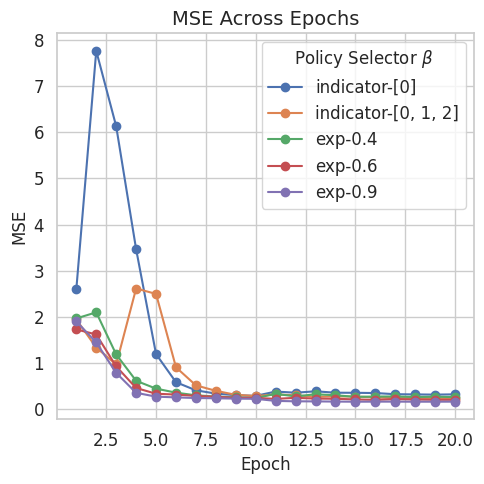

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
# plt.figure(figsize=(8, 5))
plt.figure(figsize=(5, 5))

for index, row in epoch_MSE_df.iterrows():
    plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend(title=r'Policy Selector $\beta$', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/smallactivationFuncMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

## Minibatch Size

In [163]:
import os
import json
import pandas as pd

epochs = torch.arange(20)+1

# Specify the full path to the directory
path = "/home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6"


experiment = []
short_experiment = []
simulation_performance = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


for folder_name in os.listdir(path):
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print("Folder:", full_path)

        # Read data
        json_info_path = os.path.join(full_path, "info.json")
        json_data_path = os.path.join(full_path, "results.json")
        
        if os.path.isfile(json_info_path):
            with open(json_info_path, 'r') as json_file:
                info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", info_dict)  # You can process the dictionary as needed
        if os.path.isfile(json_data_path):
            with open(json_data_path, 'r') as json_file:
                data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", data_dict)  # You can process the dictionary as needed


        experiment_name = f"H{info_dict['prediction_horizon_step']}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(experiment_name)
        short_experiment_name = f"{info_dict['minibatach size']}"
        print(short_experiment_name)

        sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
        # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
        print('Sim perf :',sim_perf)

        exp_MSE = data_dict['mse_encoded_action']['Total']
        print('MSE :',exp_MSE)
        # print('MSE discrete :', data_dict['mse_discrete_action']['Total'])

        experiment.append(experiment_name)
        short_experiment.append(short_experiment_name)
        simulation_performance.append(sim_perf)


        reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
        epoch_reward_df.loc[short_experiment_name] = reward_data

        MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
        epoch_MSE_df.loc[short_experiment_name] = MSE_data

        print()

new_order_positions = [3,2,0,1,4]
# Reorder the DataFrame rows
epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
epoch_reward_df

epoch_MSE_df


Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment73
H5-MB256-discrete-discrete-exp-0.6
256
Sim perf : 0.9779033096086479
MSE : 0.2764083743095398

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment103
H5-MB512-discrete-discrete-exp-0.6
512
Sim perf : 0.9488988092222366
MSE : 0.34439563751220703

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment43
H5-MB128-discrete-discrete-exp-0.6
128
Sim perf : 0.9868407791629995
MSE : 0.253457248210907

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment13
H5-MB64-discrete-discrete-exp-0.6
64
Sim perf : 0.9853899942162242
MSE : 0.20483379065990448

Folder: /home/baptiste/Downloads/Activation func data/H5 - dis dis - exp0.6/experiment133
H5-MB1024-discrete-discrete-exp-0.6
1024
Sim perf : 0.8960876413138359
MSE : 0.4876459836959839


189.951213
-124.842751


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
64,1.729125,1.620047,0.929538,0.461015,0.336581,0.318466,0.289241,0.270877,0.249217,0.244912,0.225816,0.248108,0.231842,0.227599,0.213515,0.203798,0.220032,0.211497,0.205717,0.204834
128,2.533390,1.905739,0.964814,0.501784,0.428942,0.348866,0.300841,0.292489,0.266712,0.260148,0.307607,0.273739,0.308224,0.280392,0.272660,0.272828,0.259704,0.260179,0.257591,0.253457
256,2.389279,2.455513,1.083419,0.612651,0.502619,0.415676,0.365194,0.343067,0.326946,0.320098,0.310678,0.306561,0.300674,0.291144,0.282268,0.276500,0.281164,0.279016,0.276180,0.276408
512,2.605401,2.912324,1.417843,0.972539,0.828262,0.666668,0.551651,0.451121,0.421221,0.385069,0.373796,0.362622,0.367101,0.367508,0.359683,0.353712,0.350076,0.346507,0.345502,0.344396
1024,3.432146,2.553432,2.116116,1.597777,1.326440,1.289190,1.076628,0.927312,0.793101,0.659249,0.535030,0.516593,0.504455,0.499964,0.494778,0.494415,0.492419,0.491204,0.488708,0.487646


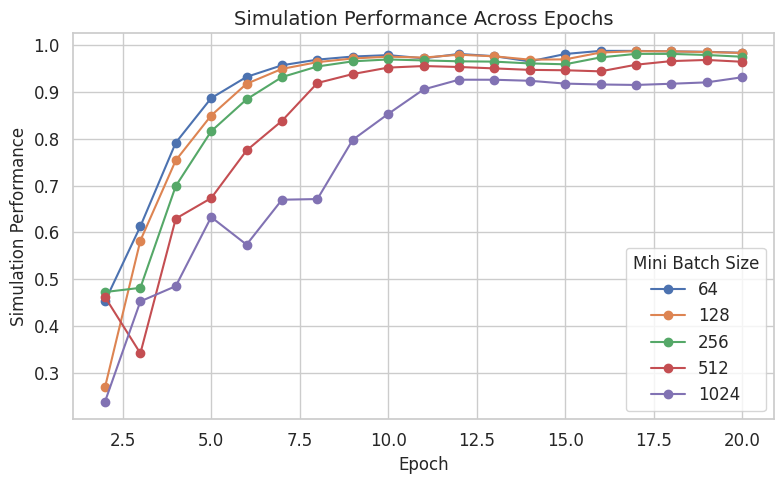

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(8, 5))

for index, row in epoch_reward_df.iterrows():
    plt.plot(epoch_reward_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('Simulation Performance Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(title=r'Mini Batch Size', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/batchSizeReward.pdf", bbox_inches='tight')

# Show the plot
plt.show()

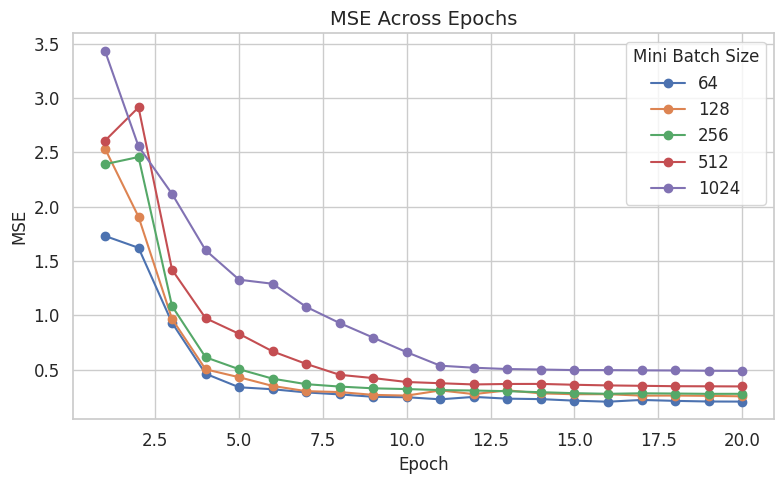

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(8, 5))

for index, row in epoch_MSE_df.iterrows():
    plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend(title=r'Mini Batch Size', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/batchSizeMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# Naive VS Dagger

In [151]:
import os
import json
import pandas as pd

epochs = torch.arange(20)+1

# Specify the full path to the directory
path = "/home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger"


experiment = []
short_experiment = []
simulation_performance = []
epoch_MSE = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


for folder_name in os.listdir(path):
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print("Folder:", full_path)

        # Read data
        json_info_path = os.path.join(full_path, "info.json")
        json_data_path = os.path.join(full_path, "results.json")
        
        if os.path.isfile(json_info_path):
            with open(json_info_path, 'r') as json_file:
                info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", info_dict)  # You can process the dictionary as needed
        if os.path.isfile(json_data_path):
            with open(json_data_path, 'r') as json_file:
                data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                # print("JSON data:", data_dict)  # You can process the dictionary as needed


        experiment_name = f"H{info_dict['prediction_horizon_step']}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
        print(experiment_name)

        if info_dict['Activation function']['type'] == 'indicator':
            name = "Naive"
        else :
            name = "DAgger"
        short_experiment_name = f"{name} : {info_dict['p_typeAction']}-{info_dict['F_typeAction']}"
        print(short_experiment_name)

        sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
        # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
        print('Sim perf :',sim_perf)

        exp_MSE = data_dict['mse_encoded_action']['Total']
        print('MSE :',exp_MSE)
        # print('MSE discrete :', data_dict['mse_discrete_action']['Total'])

        experiment.append(experiment_name)
        short_experiment.append(short_experiment_name)
        simulation_performance.append(sim_perf)
        epoch_MSE.append(exp_MSE)


        reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
        epoch_reward_df.loc[short_experiment_name] = reward_data

        MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
        epoch_MSE_df.loc[short_experiment_name] = MSE_data
        
        print()


# new_order_positions = [2, 1, 0, 3, 4]
# # Reorder the DataFrame rows
# epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
# epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
# epoch_reward_df

# epoch_MSE_df
# epoch_reward_df


Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment1
H5-MB64-discrete-discrete-exp-0.6
DAgger : discrete-discrete
Sim perf : 0.9891489036552464
MSE : 0.21850204467773438

Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment2
H5-MB64-first-spline-exp-0.6
DAgger : first-spline
Sim perf : 0.9930403105874315
MSE : 0.1870138943195343

Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment3
H5-MB64-discrete-discrete-indicator-[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Naive : discrete-discrete
Sim perf : 0.6849226786899766
MSE : 0.15462759137153625

Folder: /home/baptiste/Downloads/dagger_eval_contact_aligned_naive_vs_dagger/experiment4
H5-MB64-first-spline-indicator-[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Naive : first-spline
Sim perf : 0.5562720777991041
MSE : 0.1613275110721588


191.064917
-71.950897


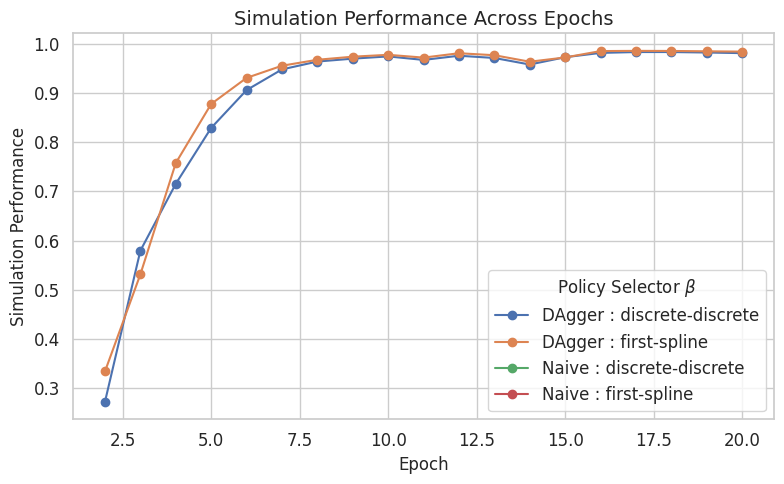

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(8, 5))

for index, row in epoch_reward_df.iterrows():
    plt.plot(epoch_reward_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('Simulation Performance Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(title=r'Policy Selector $\beta$', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/DaggervsNaiceReward.pdf", bbox_inches='tight')

# Show the plot
plt.show()

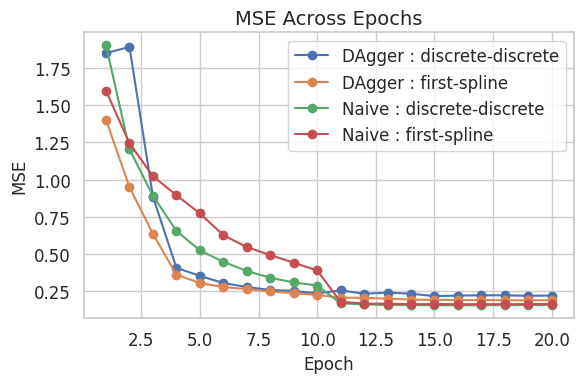

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(6, 4))

for index, row in epoch_MSE_df.iterrows():
    plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# Full Evalutation across Encodings

In [ ]:
import os
import json
import pandas as pd
import torch

epochs = torch.arange(20)+1

# Specify the full path to the directory
path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/dagger/dagger_eval_contact_aligned_full_eval"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/dagger/dagger_eval_contact_aligned_full_eval2"


experiment = []
short_experiment = []
simulation_performance = []
epoch_MSE = []

epoch_reward_df = pd.DataFrame(columns=list(range(1, 21)))
epoch_MSE_df = pd.DataFrame(columns=list(range(1, 21)))


multi_columns = pd.MultiIndex.from_product([
    ['mse_first_action', 'mse_discrete_action', 'mse_encoded_action'], 
    ['f', 'd', 'p', 'F', 'Total']
])
result_df = pd.DataFrame(columns=multi_columns)


for path in [path1, path2]:
    for folder_name in os.listdir(path):
        full_path = os.path.join(path, folder_name)
        if os.path.isdir(full_path):
            print("Folder:", full_path)

            # Read data
            json_info_path = os.path.join(full_path, "info.json")
            json_data_path = os.path.join(full_path, "results.json")
            
            if os.path.isfile(json_info_path):
                with open(json_info_path, 'r') as json_file:
                    info_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                    # print("JSON data:", info_dict)  # You can process the dictionary as needed
            if os.path.isfile(json_data_path):
                with open(json_data_path, 'r') as json_file:
                    data_dict = json.load(json_file)  # Load JSON data into a Python dictionary
                    # print("JSON data:", data_dict)  # You can process the dictionary as needed


            experiment_name = f"H{info_dict['prediction_horizon_step']}-dt{info_dict['prediction_horizon_time'][0:4]}-MB{info_dict['minibatach size']}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}-{info_dict['Activation function']['type']}-{info_dict['Activation function']['param']}"
            print(experiment_name)


            short_experiment_name = f"H{info_dict['prediction_horizon_step']}-dt{info_dict['prediction_horizon_time'][0:4]}-{info_dict['p_typeAction']}-{info_dict['F_typeAction']}"
            print(short_experiment_name)

            sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud']) / (data_dict['Epoch_Reward']['epoch_reward_test'] - data_dict['untrained_stud_Epoch_Reward']['epoch_reward_untrained_stud'])
            # sim_perf = (data_dict['Epoch_Reward']['epoch_reward_stud']) 
            print('Sim perf :',sim_perf)

            exp_MSE = data_dict['mse_encoded_action']['Total']
            print('MSE :',exp_MSE)
            # print('MSE discrete :', data_dict['mse_discrete_action']['Total'])

            experiment.append(experiment_name)
            short_experiment.append(short_experiment_name)
            simulation_performance.append(sim_perf)
            epoch_MSE.append(exp_MSE)


            reward_data = pd.read_csv(os.path.join(full_path, "average_epoch_reward.csv"), header=None).values.flatten()
            epoch_reward_df.loc[short_experiment_name] = reward_data

            MSE_data = pd.read_csv(os.path.join(full_path, "epoch_mse_test_loss.csv"), header=None).values[:,-1].flatten()
            epoch_MSE_df.loc[short_experiment_name] = MSE_data


            # Extract relevant data from the JSON
            row_data = {
                ('mse_first_action', 'f'): data_dict['mse_first_action']['f'],
                ('mse_first_action', 'd'): data_dict['mse_first_action']['d'],
                ('mse_first_action', 'p'): data_dict['mse_first_action']['p'],
                ('mse_first_action', 'F'): data_dict['mse_first_action']['F'],
                ('mse_first_action', 'Total'): data_dict['mse_first_action']['Total'],
                
                ('mse_discrete_action', 'f'): data_dict['mse_discrete_action']['f'],
                ('mse_discrete_action', 'd'): data_dict['mse_discrete_action']['d'],
                ('mse_discrete_action', 'p'): data_dict['mse_discrete_action']['p'],
                ('mse_discrete_action', 'F'): data_dict['mse_discrete_action']['F'],
                ('mse_discrete_action', 'Total'): data_dict['mse_discrete_action']['Total'],
                
                ('mse_encoded_action', 'f'): data_dict['mse_encoded_action']['f'],
                ('mse_encoded_action', 'd'): data_dict['mse_encoded_action']['d'],
                ('mse_encoded_action', 'p'): data_dict['mse_encoded_action']['p'],
                ('mse_encoded_action', 'F'): data_dict['mse_encoded_action']['F'],
                ('mse_encoded_action', 'Total'): data_dict['mse_encoded_action']['Total'],

                # 'reward' : sim_perf,
            }

            result_df.loc[short_experiment_name] = pd.Series(row_data)
            result_df.loc[short_experiment_name,'Dimension'] = info_dict['Output_size']
            result_df.loc[short_experiment_name,'reward'] = data_dict['Epoch_Reward']['epoch_reward_test']
            result_df.loc[short_experiment_name,'scaled reward'] = 100*sim_perf
            
            print()


# new_order_positions = [2, 1, 0, 3, 4]
# # Reorder the DataFrame rows
# epoch_reward_df = epoch_reward_df.iloc[new_order_positions]
# epoch_MSE_df = epoch_MSE_df.iloc[new_order_positions]


reward_max = epoch_reward_df.max().max()
reward_min = epoch_reward_df.min().min()
print()
print(reward_max)
print(reward_min)


# rescale epoch reward
# epoch_reward_df = (epoch_reward_df - reward_min + 100) / (reward_max - reward_min + 105)
# epoch_reward_df

# epoch_MSE_df
# epoch_reward_df


In [ ]:
epoch_reward_df

In [ ]:
display(result_df.sort_values(by='scaled reward'))

In [112]:
df = result_df

def parse_index(index_str):
    h, dt, encodingP, encodingF = index_str.split('-')
    h_value = int(h[1:])  # Extract the number from H (e.g., H15 -> 15)
    dt_value = float(dt[2:])  # Extract the number from dt (e.g., dt0.04 -> 0.04)
    return h_value, dt_value, encodingP, encodingF

# Apply the parsing function to create separate columns
df[['H', 'dt', 'encodingP', 'encodingF']] = df.index.to_series().apply(parse_index).apply(pd.Series)


# Step 2: Set the MultiIndex
df.set_index(['dt', 'H', 'encodingP', 'encodingF'], inplace=True)

# Step 3: Sort the DataFrame by dt first, then by H
df.sort_index(level=['dt', 'H'], inplace=True)

display(df)

mse_first_action                                \
                                           f         d         p         F   
dt   H  encodingP encodingF                                                  
0.02 5  discrete  discrete          0.008919  0.034634  0.034517  0.030903   
                  spline            0.009377  0.034971  0.035089  0.031998   
        first     discrete          0.007803  0.020633  0.021737  0.021591   
                  spline            0.007143  0.018754  0.020568  0.019723   
        spline    discrete          0.008837  0.029491  0.030683  0.029826   
                  spline            0.007789  0.025380  0.027477  0.026246   
     10 discrete  discrete          0.012520  0.075962  0.075591  0.068574   
                  spline            0.013791  0.066330  0.071333  0.090137   
        first     discrete          0.010212  0.041085  0.041916  0.040617   
                  spline            0.010049  0.035249  0.034789  0.061048   
        spline    discrete          0.013599  0.072609  0.153057  0.063370   
                  spline            0.012726  0.060921  0.145906  0.085272   
     15 discrete  discrete          0.018411  0.121788  0.117390  0.097188   
                  spline            0.017564  0.102039  0.111437  0.208304   
        first     discrete          0.012192  0.069131  0.069487  0.060035   
                  spline            0.012156  0.049449  0.056396  0.163549   
        spline    discrete          0.017892  0.126349  0.821107  0.105362   
                  spline            0.016862  0.104264  0.788095  0.205665   
0.04 5  discrete  discrete          0.010105  0.042410  0.044632  0.039599   
                  spline            0.011203  0.047456  0.052571  0.042400   
        first     discrete          0.008223  0.024804  0.026132  0.026444   
                  spline            0.008986  0.028300  0.030149  0.029633   
        spline    discrete          0.010301  0.045187  0.044718  0.040219   
                  spline            0.013075  0.051167  0.055234  0.048526   
     10 discrete  discrete          0.015160  0.106387  0.102606  0.080855   
                  spline            0.015961  0.082462  0.098826  0.161713   
        first     discrete          0.011899  0.053732  0.049712  0.048211   
                  spline            0.010981  0.039308  0.044311  0.131628   
        spline    discrete          0.018619  0.105616  0.677458  0.092035   
                  spline            0.020318  0.098860  0.665307  0.164644   
     15 discrete  discrete          0.019437  0.131450  0.125792  0.113165   
                  spline            0.021206  0.129054  0.124624  0.385817   
        first     discrete          0.012462  0.060859  0.063828  0.055202   
                  spline            0.012726  0.051219  0.057940  0.331764   
        spline    discrete          0.023359  0.183145  2.560268  0.141942   
                  spline            0.024835  0.171115  2.530354  0.372449   

                                      mse_discrete_action            \
                                Total                   f         d   
dt   H  encodingP encodingF                                           
0.02 5  discrete  discrete   0.029328            0.008919  0.034634   
                  spline     0.030074            0.009377  0.034971   
        first     discrete   0.019526            0.007803  0.020633   
                  spline     0.018029            0.007143  0.018754   
        spline    discrete   0.027024            0.008837  0.029491   
                  spline     0.023837            0.007789  0.025380   
     10 discrete  discrete   0.063627            0.012520  0.075962   
                  spline     0.070457            0.013791  0.066330   
        first     discrete   0.036711            0.010212  0.041085   
                  spline     0.042574            0.010049  0.035249   
        spline    discrete   0.083204            0.013599  0.0

In [ ]:
result_df

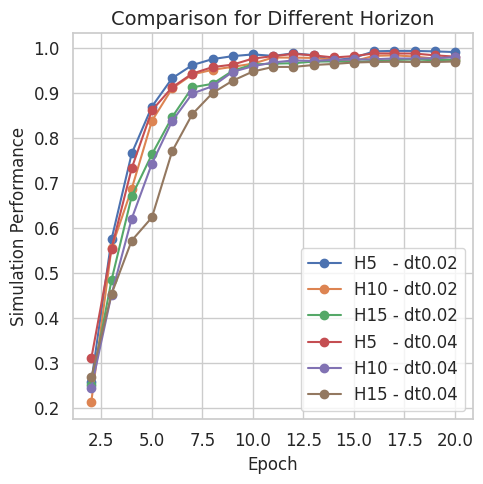

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(5, 5))
# plt.figure(figsize=(18, 12))

# for index, row in epoch_reward_df.iterrows():
#     print(index)
#     if "first-spline" in index or "discrete-discrete" in index:
#         if "0.02" in index:
#             y = (row + 110)/303
#             plt.plot(epoch_reward_df.columns, y, marker='o', label=index)

index =  ['H5-dt0.02-discrete-discrete', 'H10-dt0.02-discrete-discrete', 'H15-dt0.02-discrete-discrete']#,'H5-dt0.02-first-spline', 'H10-dt0.02-first-spline', 'H15-dt0.02-first-spline']
label =  ['H5   - dt0.02', 'H10 - dt0.02', 'H15 - dt0.02']#,'H5   - first-spline', 'H10 - first-spline', 'H15 - first-spline']

for i in range(len(index)):
        # print()
        # print(index[i])
        # print(result_df.loc[index[i], 'scaled reward'].values)
        y = (epoch_reward_df.loc[index[i]]+210)/403
        # print(y[20])
        plt.plot(epoch_reward_df.columns, y, marker='o', label=label[i])

index =  ['H5-dt0.04-discrete-discrete', 'H10-dt0.04-discrete-discrete', 'H15-dt0.04-discrete-discrete']#,'H5-dt0.04-first-spline', 'H10-dt0.04-first-spline', 'H15-dt0.04-first-spline']
label =  ['H5   - dt0.04', 'H10 - dt0.04', 'H15 - dt0.04']#,'H5   - first-spline', 'H10 - first-spline', 'H15 - first-spline']

for i in range(len(index)):
        # print()
        # print(index[i])
        # print(result_df.loc[index[i], 'scaled reward'].values)
        y = (epoch_reward_df.loc[index[i]]+350)/735
        # print(y[20])
        plt.plot(epoch_reward_df.columns, y, marker='o', label=label[i])

# Customize the plot for the scientific report
plt.title('Comparison for Different Horizon', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/simPerf_diff_H.pdf", bbox_inches='tight')

# Show the plot
plt.show()

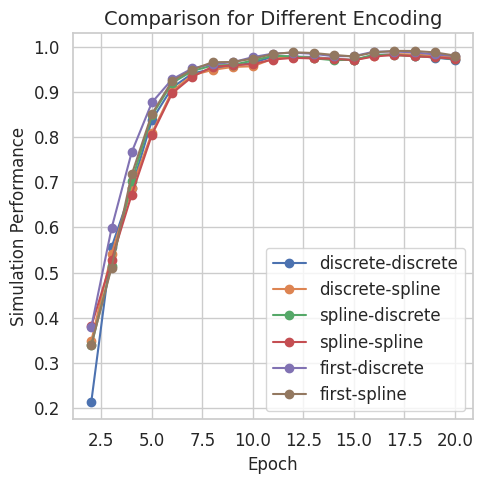

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(5, 5))
# plt.figure(figsize=(18, 12))

# for index, row in epoch_reward_df.iterrows():
#     print(index)
#     # if "first-spline" in index or "discrete-discrete" in index:
#     if "H10-dt0.02" in index:
#             y = (row + 110)/303
#             plt.plot(epoch_reward_df.columns, y, marker='o', label=index)

index =  ['H10-dt0.02-discrete-discrete', 'H10-dt0.02-discrete-spline', 'H10-dt0.02-spline-discrete','H10-dt0.02-spline-spline', 'H10-dt0.02-first-discrete', 'H10-dt0.02-first-spline']
label =  ['discrete-discrete', 'discrete-spline', 'spline-discrete', 'spline-spline', 'first-discrete', 'first-spline']

for i in range(len(index)):
        y = (epoch_reward_df.loc[index[i]] + 210)/403
        plt.plot(epoch_reward_df.columns, y, marker='o', label=label[i])

# Customize the plot for the scientific report
plt.title('Comparison for Different Encoding', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Simulation Performance', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/simPerf_diff_Encoding.pdf", bbox_inches='tight')

# Show the plot
plt.show()

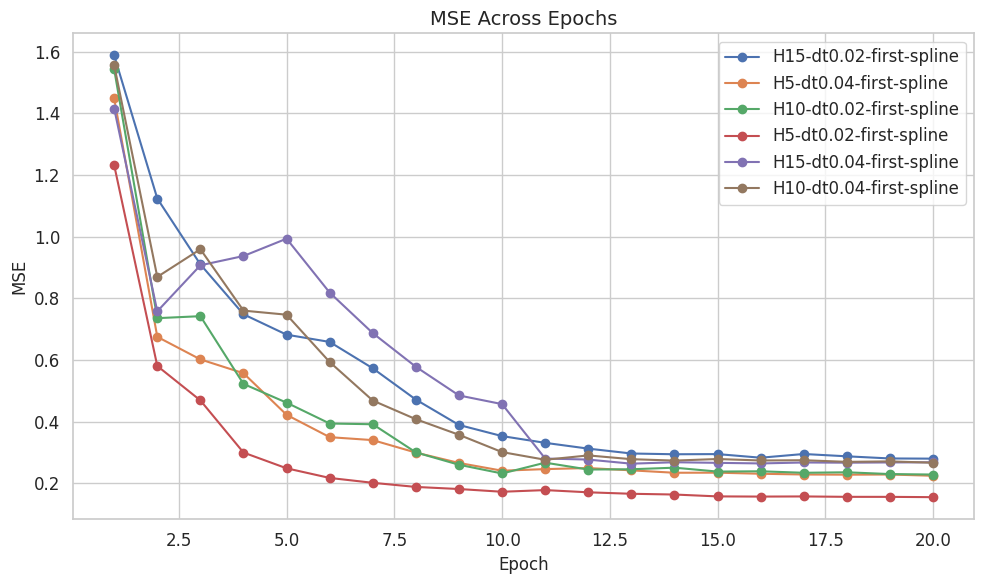

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that seaborn's style is set for better aesthetics
sns.set_theme(style=style_theme)

# Plot each row of the DataFrame as a line
plt.figure(figsize=(10, 6))

for index, row in epoch_MSE_df.iterrows():
    if "first-spline" in index :#or "first-discrete" in index:
        plt.plot(epoch_MSE_df.columns, row, marker='o', label=index)

# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot if needed
plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

In [117]:
import os
import json
import pandas as pd
import torch

# Specify the full path to the directory
path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}

df = pd.DataFrame(info_dict).T 


# Step 2: Parse the index to create MultiIndex
df.index = df.index.str.split('-').map(lambda x: (x[2], x[3], x[0], x[1]))  # Reorder as needed
df.index = pd.MultiIndex.from_tuples(df.index, names=["H", "dt", "encodingP", "encodingF"])

# Step 3: Sort the DataFrame by the MultiIndex
df = df.sort_index(level=["dt", "H"])

# Extract the numeric part of the 'H' level and convert it to an integer
h_numeric = df.index.get_level_values('H').map(lambda x: int(x[1:]))

# Divide 'sampling_cost_median_all' by the numeric part of 'H'
df['step_sampling_cost_median_all'] = df['sampling_cost_median_all'] / h_numeric

# Display the DataFrame
display(df)



rewards_median_all sampling_cost_median_all  \
H   dt   encodingP encodingF                                               
H10 dt02 discrete  discrete            0.044573              4405.479492   
                   spline              0.044242              4697.217285   
         first     discrete             0.04488              3965.626465   
                   spline              0.044798              4034.588867   
         spline    discrete            0.044576              4450.412598   
                   spline              0.044492              4279.882812   
H15 dt02 discrete  discrete            0.044154             17056.167969   
                   spline              0.044138             17003.671875   
         first     discrete            0.044699             17394.777344   
                   spline              0.044648             16702.007812   
         spline    discrete            0.043806             18934.308594   
                   spline              0.043489             19794.929688   
H5  dt02 discrete  discrete            0.044788               944.154175   
                   spline              0.044811                951.28772   
         first     discrete            0.045137               880.672852   
                   spline              0.045064               881.979065   
         spline    discrete             0.04502               936.163757   
                   spline              0.044876               984.588684   
H10 dt04 discrete  discrete            0.044395             27729.855469   
                   spline              0.044324             26399.660156   
         first     discrete            0.044928               33801.1875   
                   spline              0.044794              34957.71875   
         spline    discrete            0.044178             35092.292969   
                   spline              0.044167             36003.945312   
H15 dt04 discrete  discrete            0.044205                 374743.5   
                   spline              0.043443             476713.15625   
         first     discrete            0.044718               621315.625   
                   spline              0.044291                734597.75   
         spline    discrete            0.037133               1422522.75   
                   spline              0.039761               1781022.25   
H5  dt04 discrete  discrete            0.044812              2119.692383   
                   spline              0.044692              2207.054199   
         first     discrete            0.045087              1955.963623   
                   spline              0.044927              2088.513184   
         spline    discrete            0.044862              2057.154541   
                   spline              0.044635              2120.180664   

                                                              step_cost_results  \
H   dt   encodingP encodingF                                                      
H10 dt02 discrete  discrete   {'step_cost_mean': [278.6075134277344, 323.534...   
                   spline     {'step_cost_mean': [345.8993225097656, 405.567...   
         first     discrete   {'step_cost_mean': [231.40853881835938, 269.11...   
                   spline     {'step_cost_mean': [242.1888427734375, 287.128...   
         spline    discrete   {'step_cost_mean': [289.6379699707031, 338.000...   
                   spline     {'step_cost_mean': [273.2339172363281, 322.659...   
H15 dt02 discrete  discrete   {'step_cost_mean': [313.0076599121094, 335.640...   
                   spline     {'step_cost_mean': [321.70843505859375, 344.52...   
         first     discrete   {'step_cost_mean': [255.8956756591797, 275.338...   
                   spline     {'step_cost_mean': [263.328125, 279.2749633789...   
         spline    discrete   {'step_cost_mean': [327.9464111328125, 353.724...   
                   spline     {'step_cost_mean': [395.7330627

In [ ]:
# Specify the full path to the directory
path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}

# print(info_dict)

step_cost_df = pd.DataFrame(columns=range(15))
for key in info_dict : 
    step_cost_df.loc[key] = info_dict[key]['step_cost_results']['step_cost_mean']
    # print(info_dict[key]['step_cost_results'])

display(step_cost_df)

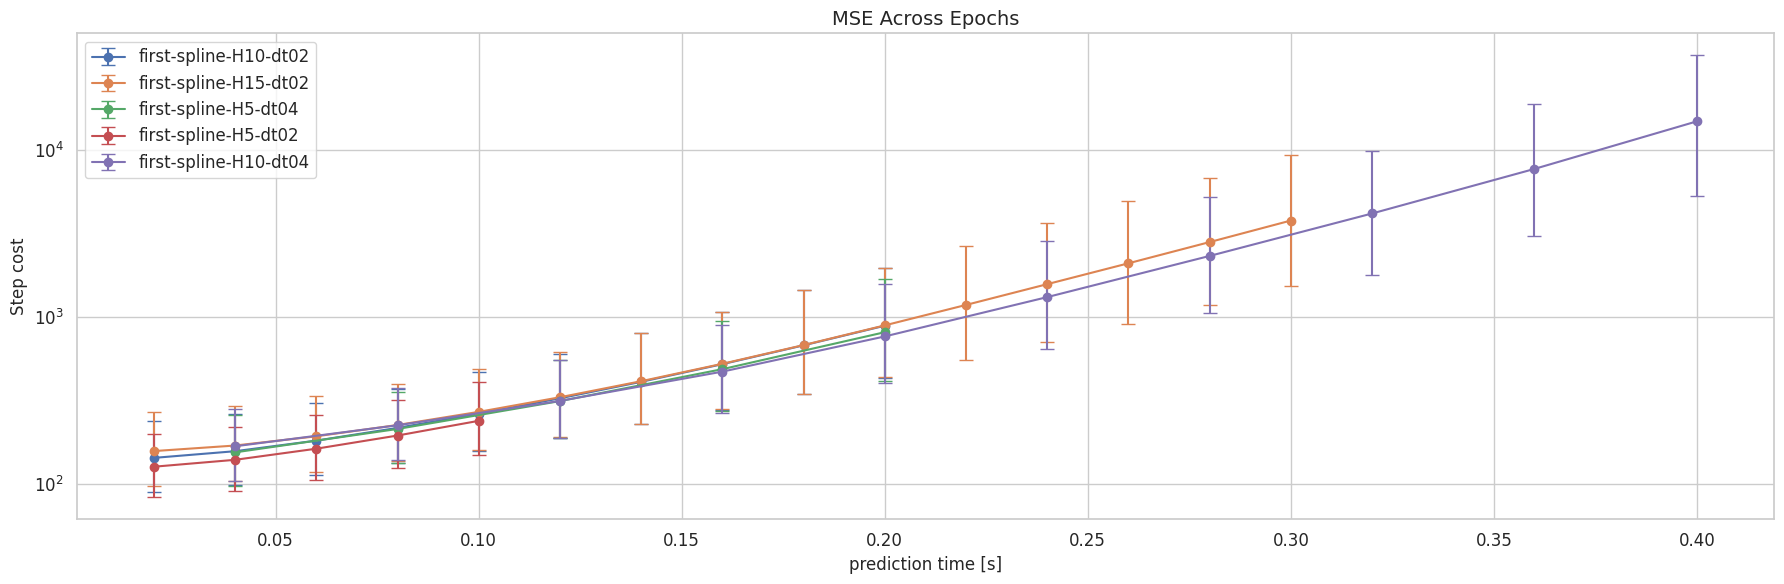

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style=style_theme)
plt.figure(figsize=(18, 6))


path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}



for key in info_dict : 
    if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H5' in key:
        # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
        y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])

        q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
        q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])
        yerr = [y - q1, q3 - y]

        if '02' in key:
            x = torch.arange(len(y))*0.02 + 0.02
        else :
            x = torch.arange(len(y))*0.04 + 0.04

        # plt.plot(x,y, marker='o', label=key)
        plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)


# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

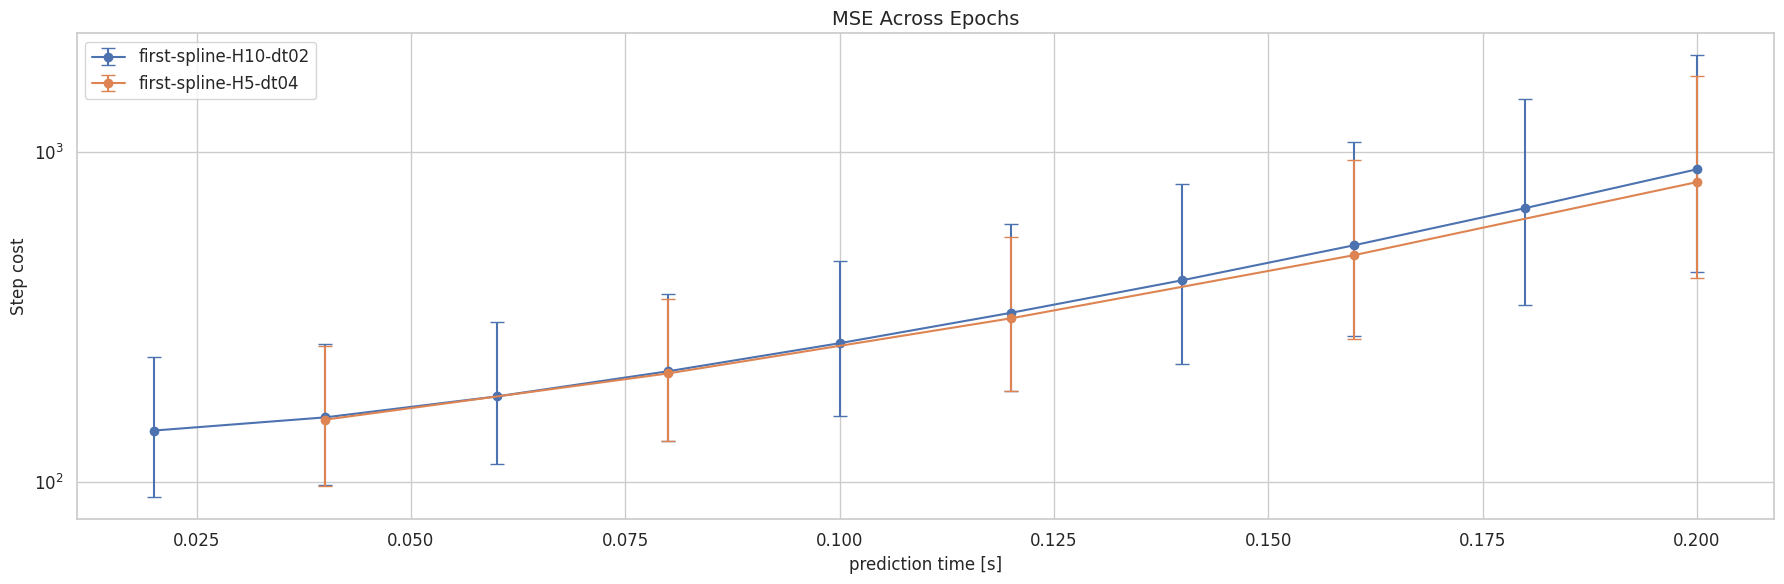

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style=style_theme)
plt.figure(figsize=(18, 6))


path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict}



for key in info_dict : 
    if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H10' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])

            q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key:
                x = torch.arange(len(y))*0.02 + 0.02
            else :
                x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key)
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)


# Customize the plot for the scientific report
plt.title('MSE Across Epochs', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

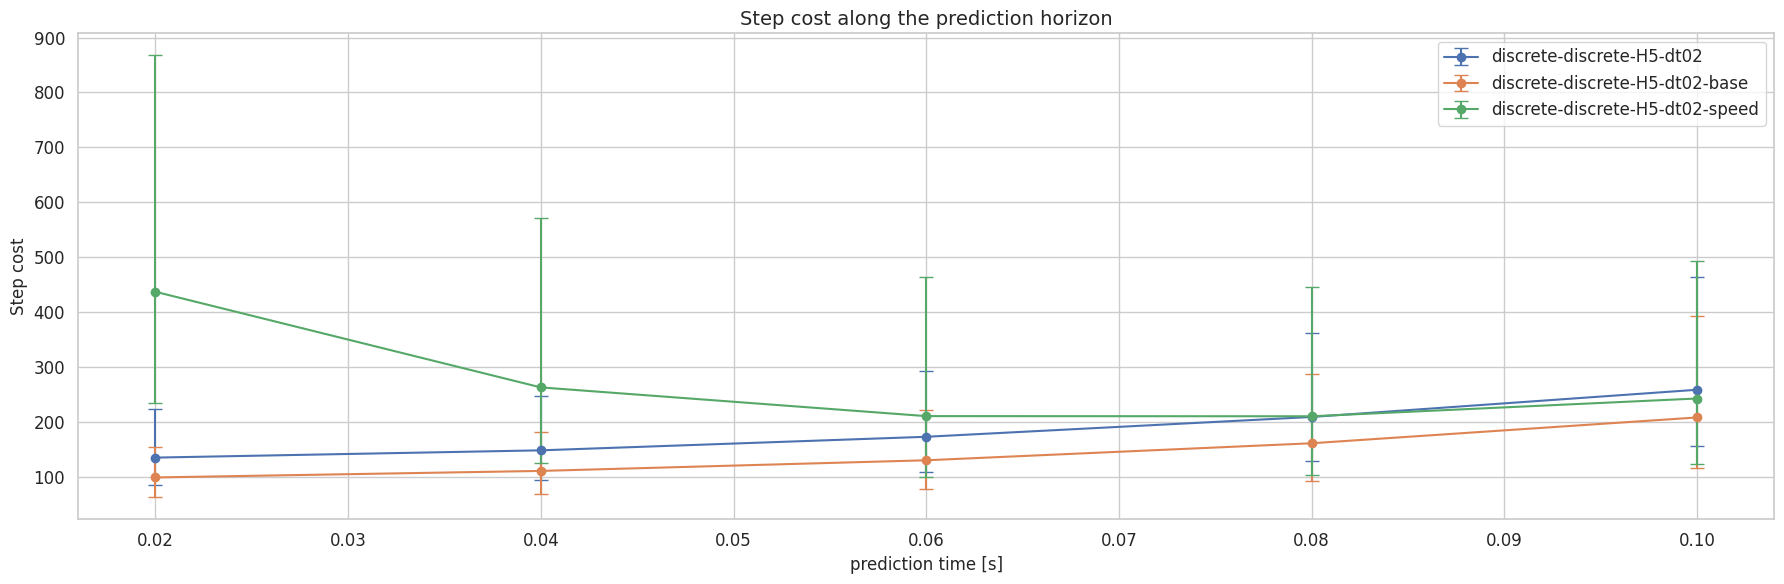

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(18, 6))


path1 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost"
path2 = "/home/baptiste/Downloads/results_dagger_full_eval_base_task/eval/dagger_eval_contact_aligned_full_eval_sampCost2"
path3 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingTrainer_Eval_H5_Dis_Dis"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
json_info_path3 = os.path.join(path3, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info1_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info2_dict = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path3):
    with open(json_info_path3, 'r') as json_file:
        info3_dict = json.load(json_file)  # Load JSON data into a Python dictionary
info_dict = {**info1_dict, **info2_dict, **info3_dict}



for key in info_dict : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    if 'H5-dt02' in key:
        if 'discrete-discrete' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])

            q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key:
                x = torch.arange(len(y))*0.02 + 0.02
            else :
                x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key)
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)


# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# Evaluation with the Controller

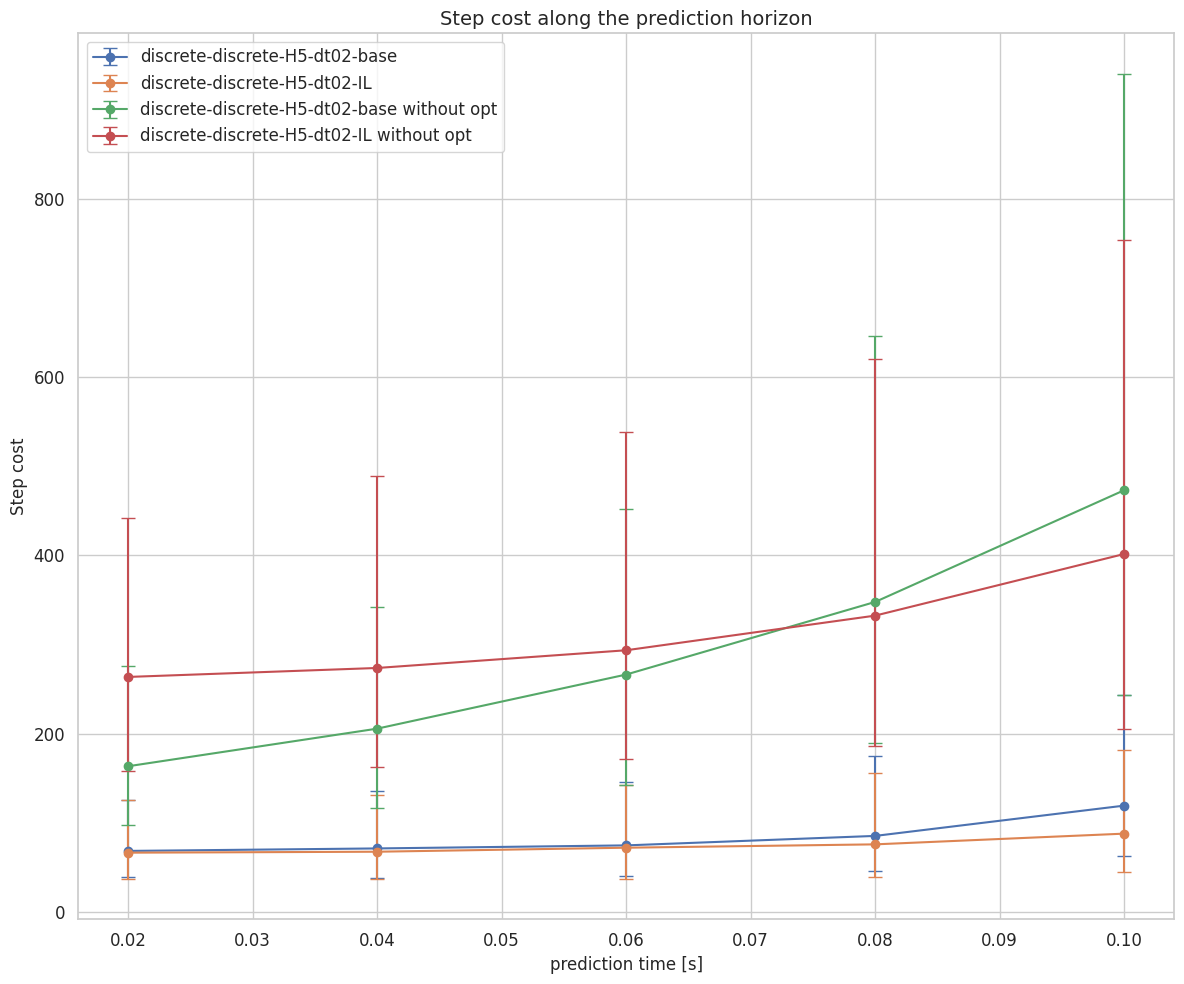

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path1 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingController_Eval_H5_Dis_Dis"
path2 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingTrainer_Eval_H5_Dis_Dis"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info_dict_without_optimization = json.load(json_file)  # Load JSON data into a Python dictionary
# info_dict = {**info1_dict}#, **info2_dict}#, **info3_dict}


for key in info_dict_with_opt : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H5-dt02' in key:
    if not "speed" in key:
        # if 'discrete-discrete' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key)
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

for key in info_dict_without_optimization : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    # if 'H5-dt02' in key:
    if not "speed" in key:
        # if 'discrete-discrete' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_without_optimization[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            # plt.plot(x,y, marker='o', label=key + ' without opt')
            plt.errorbar(x, y, yerr=yerr, marker='o', label=key + ' without opt', capsize=5)


# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path1 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingController_dagger_contact_aligned"
path2 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/samplingTrainer_dagger_contact_aligned"

json_info_path1 = os.path.join(path1, "info.json")
json_info_path2 = os.path.join(path2, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  # Load JSON data into a Python dictionary
if os.path.isfile(json_info_path2):
    with open(json_info_path2, 'r') as json_file:
        info_dict_without_optimization = json.load(json_file)  # Load JSON data into a Python dictionary
# info_dict = {**info1_dict}#, **info2_dict}#, **info3_dict}


for key in info_dict_with_opt : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    if 'H5-dt02' in key:
        if 'discrete-discrete' in key or 'first-spline' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            plt.plot(x,y, marker='o', label=key)
            # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

for key in info_dict_without_optimization : 
    # if 'first-spline' in key and not 'H15-dt04' in key:
    if 'H5-dt02' in key:
        if 'discrete-discrete' in key or 'first-spline' in key:
        # if 'first-discrete' in key or 'first-spline' in key :
        # if 'first-spline-H5-dt04' in key or 'first-spline-H10-dt02' in key:
            # y = [0] + info_dict[key]['step_cost_results']['step_cost_median']
            y = np.array(info_dict_without_optimization[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_without_optimization[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            plt.plot(x,y, marker='o', label=key + ' without opt')
            # plt.errorbar(x, y, yerr=yerr, marker='o', label=key + ' without opt', capsize=5)


# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

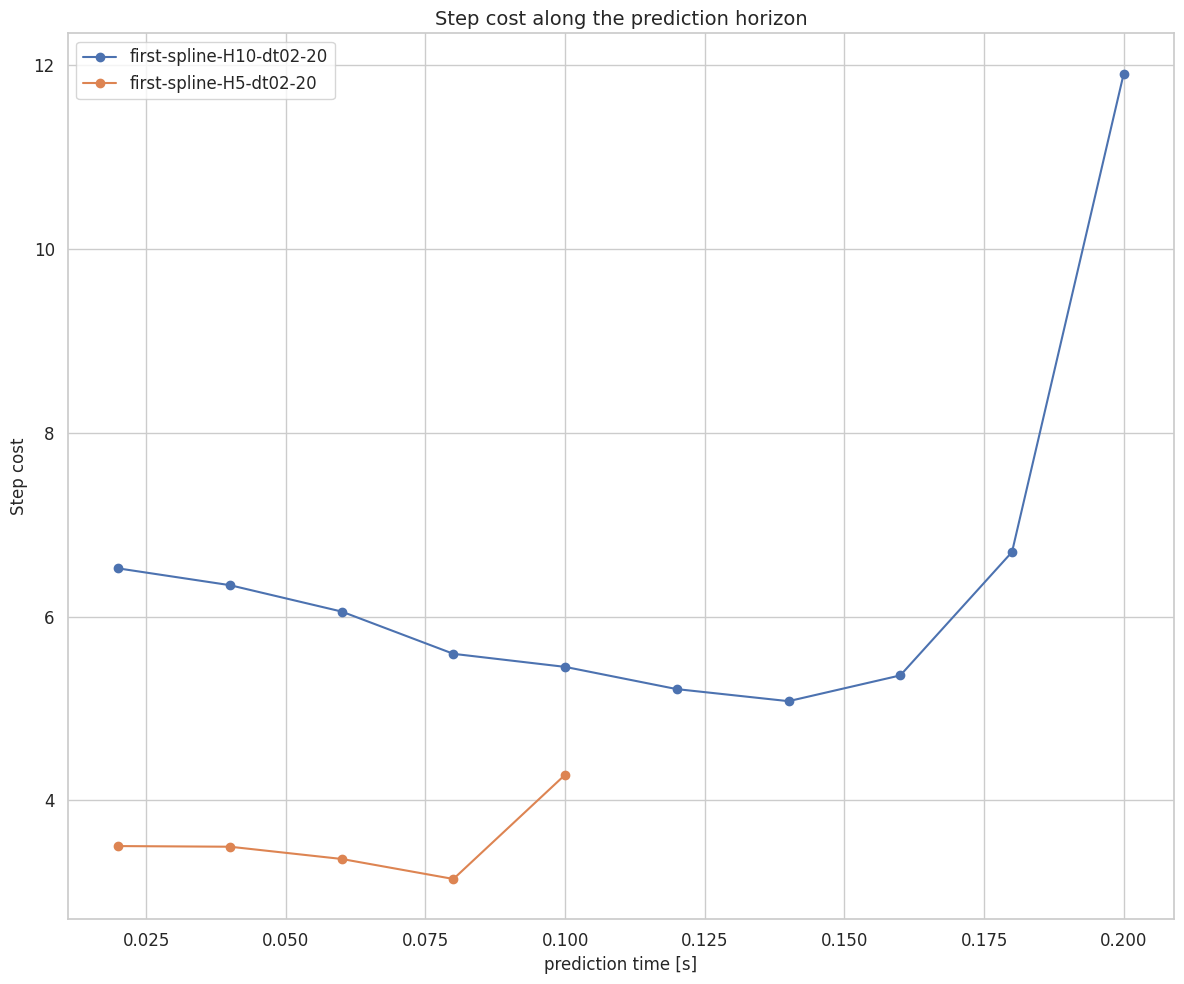

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path1 = "/home/baptiste/Documents/dls_isaac_lab_bat_private/eval/Simple_Eval_vs_Mujoco"

info_dict_with_opt = {}
json_info_path1 = os.path.join(path1, "info.json")
if os.path.isfile(json_info_path1):
    with open(json_info_path1, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  


for key in info_dict_with_opt : 
            y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
            q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
            q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
            yerr = [y - q1, q3 - y]

            if '02' in key: x = torch.arange(len(y))*0.02 + 0.02
            else :          x = torch.arange(len(y))*0.04 + 0.04

            plt.plot(x,y, marker='o', label=key)
            # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)



# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

# 2. Effect of Action Encoding on sampling controller

,Reward,Sampling_Cost,Sampling_Cost_q1,Sampling_Cost_q3,initial_Cost,initial_Cost_q3,initial_Cost_q1
first-spline-H10-dt02-samples10000--,0.023471,291.796173,191.168244,421.319901,30.722523,40.787907,23.025379
first-discrete-H10-dt02-samples10000--,0.023385,432.852875,262.082226,668.105534,35.153690,49.648914,25.234606
discrete-spline-H10-dt02-samples10000--,0.023359,485.023438,296.748880,710.862556,46.278931,64.719833,32.534592
spline-spline-H10-dt02-samples10000--,0.023331,455.661407,243.339365,761.255539,45.726044,73.376190,28.535692
spline-discrete-H10-dt02-samples10000--,0.023247,581.947510,340.115469,964.463860,47.562286,72.609299,31.815327
discrete-discrete-H10-dt02-samples10000--,0.023201,787.271729,468.161434,1209.398056,61.439564,88.698654,42.693871
spline-spline-H10-dt02-samples10000-no_warm_start,0.022664,218.364807,123.406769,351.627813,32.456520,53.268135,18.417671
discrete-spline-H10-dt02-samples10000-no_warm_start,0.022596,221.531189,122.248042,367.987707,33.260944,56.740700,18.453592
first-spline-H10-dt02-samples10000-no_warm_start,0.022595,211.729706,118.005145,352.480352,31.435551,54.784481,17.396032
spline-discrete-H10-dt02-samples10000-no_warm_start,0.013314,8107.576172,2733.724350,30304.225586,854.952148,2485.701904,349.131226


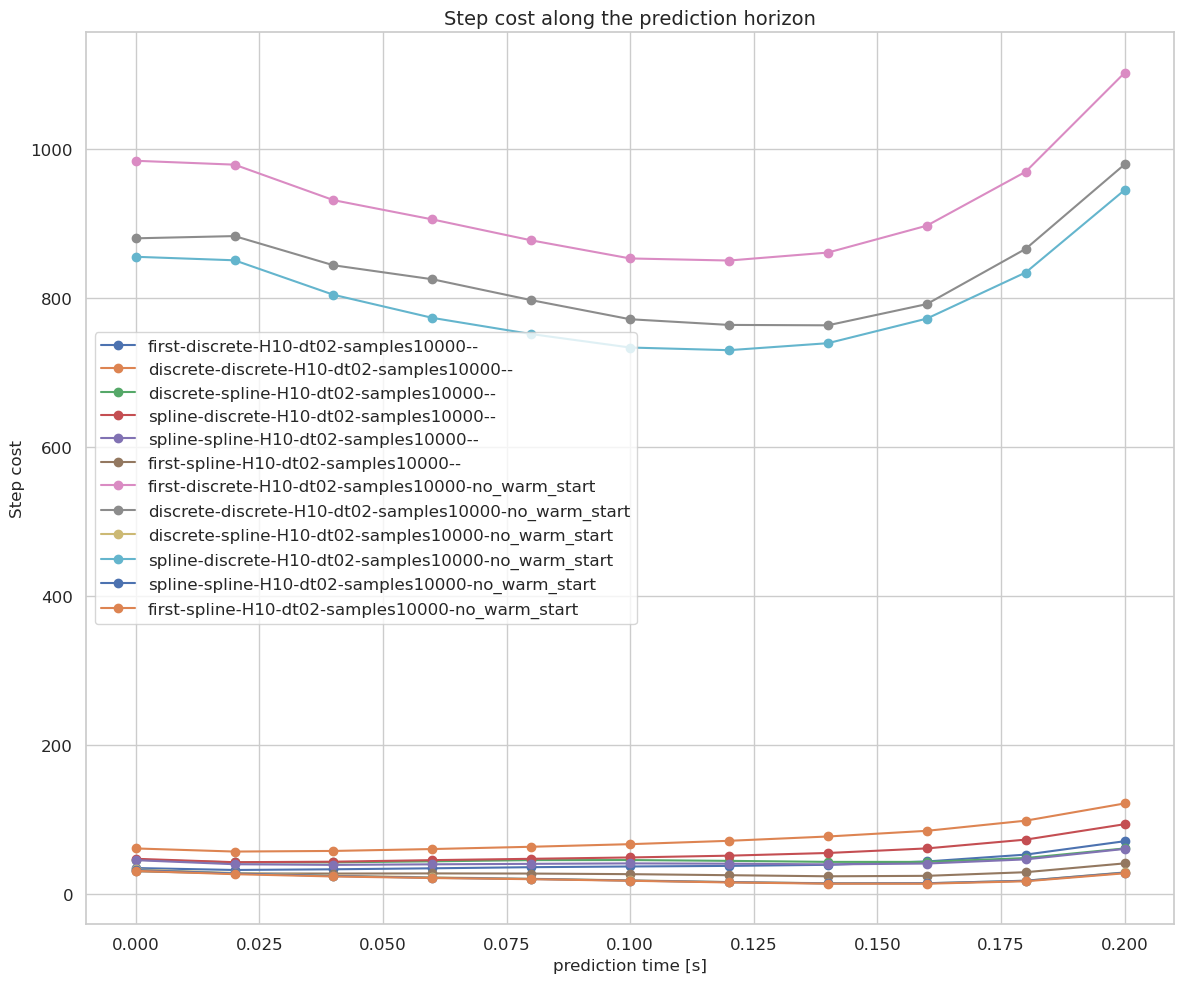

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/play_eval_H10_dt02_all_act"

info_dict = {}
with open(os.path.join(path, "info.json"), 'r') as json_file:
    info_dict = json.load(json_file)  


# key_list = ['first-discrete-H5-dt02-20', 'first-spline-H5-dt02-20', 'first-discrete-H10-dt02-20', 'first-spline-H10-dt02-20', 'first-discrete-H15-dt02-20', 'first-spline-H15-dt02-20']
# index_list = ['H05 - first-discrete', 'H05 - first-spline', 'H10 - first-discrete', 'H10 - first-spline', 'H15 - first-discrete', 'H15 - first-spline']

df = pandas.DataFrame(columns=('Reward','Sampling_Cost', 'Sampling_Cost_q1', 'Sampling_Cost_q3', 'initial_Cost', 'initial_Cost_q3', 'initial_Cost_q1'))

for key in info_dict : 
# for key in sorted(info_dict) : 
# for key in key_list : 
# for i in range(len(key_list)):    
    # key = key_list[i]

    # Save info in DF
    reward = info_dict[key]['rewards_median_all']

    sampling_cost    = info_dict[key]['sampling_cost_median_all']
    sampling_cost_q1 = sum(info_dict[key]['step_cost_results']['step_costq1_values'])
    sampling_cost_q3 = sum(info_dict[key]['step_cost_results']['step_costq3_values'])

    init_state    = info_dict[key]['step_cost_results']['initial_cost_median'][0]
    init_state_q3 = info_dict[key]['step_cost_results']['initial_costq1_values']
    init_state_q1 = info_dict[key]['step_cost_results']['initial_costq3_values']

    y = np.array(info_dict[key]['step_cost_results']['step_cost_median'])
    q1 = np.array(info_dict[key]['step_cost_results']['step_costq1_values'])
    q3 = np.array(info_dict[key]['step_cost_results']['step_costq3_values'])

    y= np.insert(y,0,init_state)
    q1 = np.insert(q1,0,init_state_q1)
    q3 = np.insert(q3,0,init_state_q3)
    yerr = [y - q1, q3 - y]

    if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
    else :          x = torch.arange(len(y))*0.04 #+ 0.04

    plt.plot(x,y, marker='o', label=key)
    # plt.plot(x,y, marker='o', label=index_list[i])
    # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

    # print(key, ' - init_state :',init_state,' - Reward :', reward, ' - sampling cost :', sampling_cost)
    df.loc[key] = [reward, sampling_cost, sampling_cost_q1, sampling_cost_q3, init_state, init_state_q1, init_state_q3]



# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.tight_layout()

display(df.sort_values(by='Reward',ascending=False))

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()

In [189]:
# Function to extract the required parts for MultiIndex
def extract_parts(idx):
    parts = idx.split('-')
    warm_start = 'no_warm_start' if 'no_warm_start' in idx else '-'
    encoding_p = parts[0]
    encoding_F = parts[1]
    return warm_start, encoding_p, encoding_F

# Apply the function to create a new MultiIndex
multi_index = pd.MultiIndex.from_tuples(df.index.map(extract_parts),
                                        names=['warm_start', 'encoding_p', 'encoding_F'])

# Set the new MultiIndex to the DataFrame
df.set_index(multi_index, inplace=True)
df.sort_index(inplace=True)

# Show the resulting DataFrame
display(df.sort_values(by='Reward', ascending=False))

Reward  Sampling_Cost  \
warm_start    encoding_p encoding_F                            
-             first      spline      0.023471     291.796173   
                         discrete    0.023385     432.852875   
              discrete   spline      0.023359     485.023438   
              spline     spline      0.023331     455.661407   
                         discrete    0.023247     581.947510   
              discrete   discrete    0.023201     787.271729   
no_warm_start spline     spline      0.022664     218.364807   
              discrete   spline      0.022596     221.531189   
              first      spline      0.022595     211.729706   
              spline     discrete    0.013314    8107.576172   
              discrete   discrete    0.012986    8512.071289   
              first      discrete    0.012422    9576.677734   

                                     Sampling_Cost_q1  Sampling_Cost_q3  \
warm_start    encoding_p encoding_F                                       
-             first      spline            191.168244        421.319901   
                         discrete          262.082226        668.105534   
              discrete   spline            296.748880        710.862556   
              spline     spline            243.339365        761.255539   
                         discrete          340.115469        964.463860   
              discrete   discrete          468.161434       1209.398056   
no_warm_start spline     spline            123.406769        351.627813   
              discrete   spline            122.248042        367.987707   
              first      spline            118.005145        352.480352   
              spline     discrete         2733.724350      30304.225586   
              discrete   discrete         2919.284027      27782.417969   
              first      discrete         2781.093887      32741.600342   

                                     initial_Cost  initial_Cost_q3  \
warm_start    encoding_p encoding_F                                  
-             first      spline         30.722523        40.787907   
                         discrete       35.153690        49.648914   
              discrete   spline         46.278931        64.719833   
              spline     spline         45.726044        73.376190   
                         discrete       47.562286        72.609299   
              discrete   discrete       61.439564        88.698654   
no_warm_start spline     spline         32.456520        53.268135   
              discrete   spline         33.260944        56.740700   
              first      spline         31.435551        54.784481   
              spline     discrete      854.952148      2485.701904   
              discrete   discrete      879.715942      2293.042969   
              first      discrete      983.719543      2651.085449   

                                     initial_Cost_q1  
warm_start    encoding_p encoding_F                   
-             first      spline            23.025379  
                         discrete          25.234606  
              discrete   spline            32.534592  
              spline     spline            28.535692  
                         discrete          31.815327  
              discrete   discrete          42.693871  
no_warm_start spline     spline            18.417671  
              discrete   spline            18.453592  
              first      spline            17.396032  
              spline     discrete         349.131226  
              discrete   discrete         375.673523  
              first      discrete         354.791534

In [126]:
df.loc['-','discrete','discrete']['Sampling_Cost']

787.271728515625

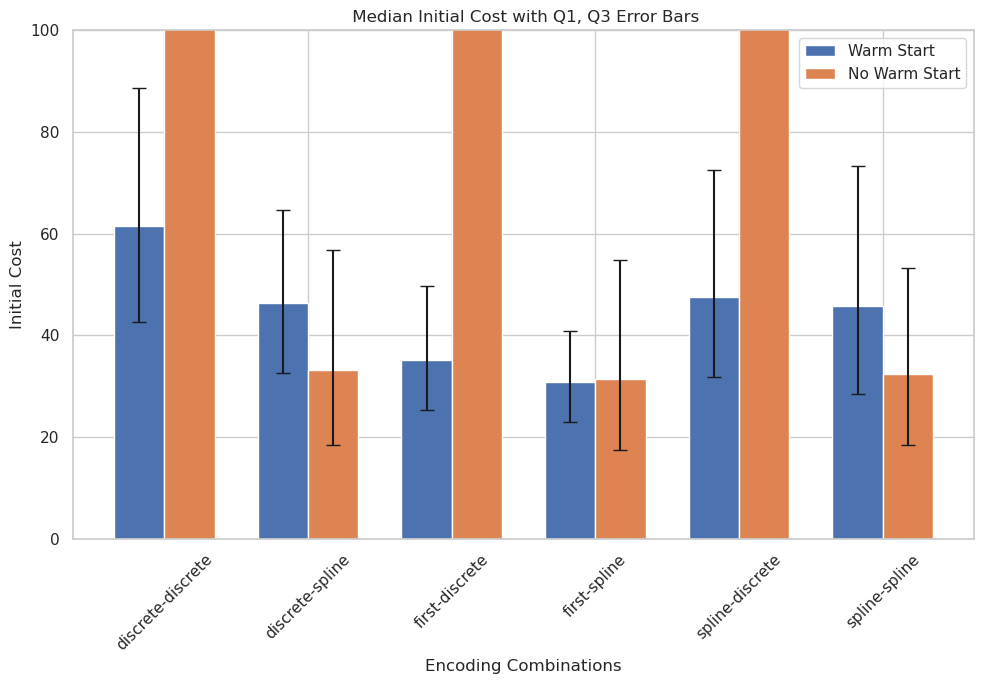

In [215]:
import matplotlib.pyplot as plt
import numpy as np

encoding_combinations = df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']

# Plotting
fig, ax = plt.subplots(figsize=(10, 7)) #(10,7)
bar_width = 0.35
index = np.arange(len(encoding_combinations))

medians, medians_nws = [], []
errors, errors_nws = [], []
for i in index :
    med     = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    med_nws = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    q1      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q1_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q3      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']
    q3_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

ax.bar(index          ,medians    , bar_width, yerr=np.array(errors).transpose()    ,label='Warm Start',    capsize=5)#, color='royalblue')
ax.bar(index+bar_width,medians_nws, bar_width, yerr=np.array(errors_nws).transpose(),label='No Warm Start', capsize=5)#, color='peru')


# Labels and title
ax.set_xlabel('Encoding Combinations')
ax.set_ylabel('Initial Cost')
ax.set_title(' Median Initial Cost with Q1, Q3 Error Bars')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{p}-{f}' for p, f in encoding_combinations], rotation=45)
ax.legend(loc='upper right')
ax.set_ylim(0,100)

# Layout and save as PDF
fig.tight_layout()
# plt.savefig('bar_plot_with_median_q1_q3.pdf')
plt.show()


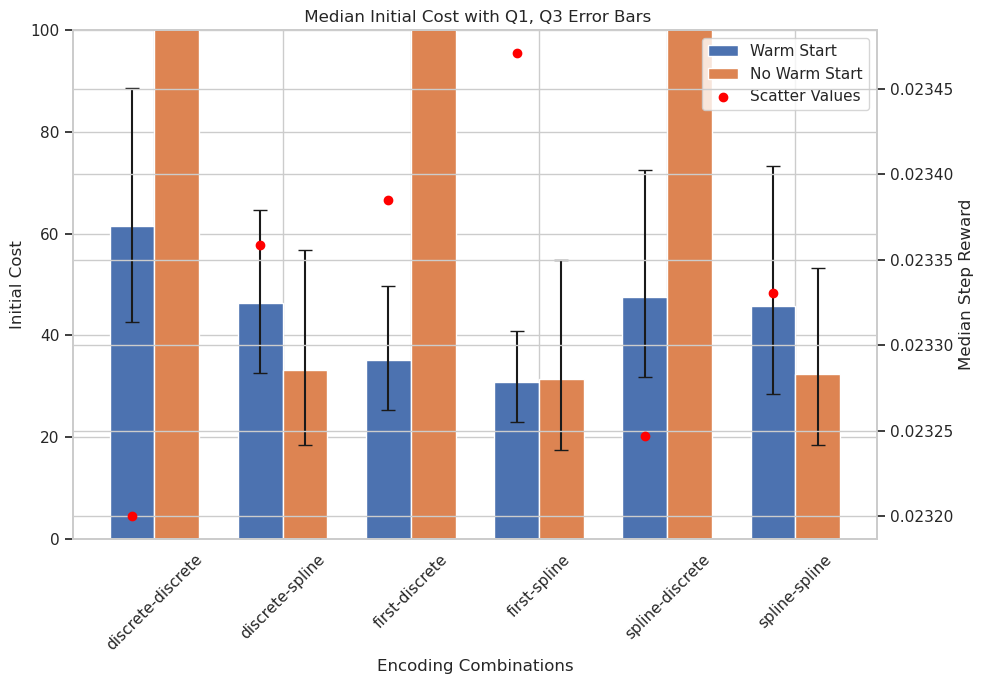

In [229]:
import matplotlib.pyplot as plt
import numpy as np

encoding_combinations = df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 7)) #(10,7)

bar_width = 0.35
index = np.arange(len(encoding_combinations))

medians, medians_nws = [], []
errors, errors_nws = [], []
reward = []
for i in index :
    med     = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    med_nws = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost']
    q1      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q1_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q1']
    q3      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']
    q3_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['initial_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

    rew    = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Reward']
    reward.append(rew)

ax1.bar(index          ,medians    , bar_width, yerr=np.array(errors).transpose()    ,label='Warm Start',    capsize=5)#, color='royalblue')
ax1.bar(index+bar_width,medians_nws, bar_width, yerr=np.array(errors_nws).transpose(),label='No Warm Start', capsize=5)#, color='peru')


ax2 = ax1.twinx()

ax2.scatter(index, reward, color='red', label='Scatter Values')
# ax2.bar(index-bar_width/2, reward, bar_width/2, color='red', label='Scatter Values')



# Labels and title
ax1.set_xlabel('Encoding Combinations')
ax1.set_ylabel('Initial Cost')
ax1.set_title(' Median Initial Cost with Q1, Q3 Error Bars')

ax2.set_ylabel('Median Step Reward')
ax2.set_ylim(0,100)

ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([f'{p}-{f}' for p, f in encoding_combinations], rotation=45)
ax1.legend(loc='upper right')
ax1.set_ylim(0,100)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Layout and save as PDF
fig.tight_layout()
# plt.savefig('bar_plot_with_median_q1_q3.pdf')
plt.show()


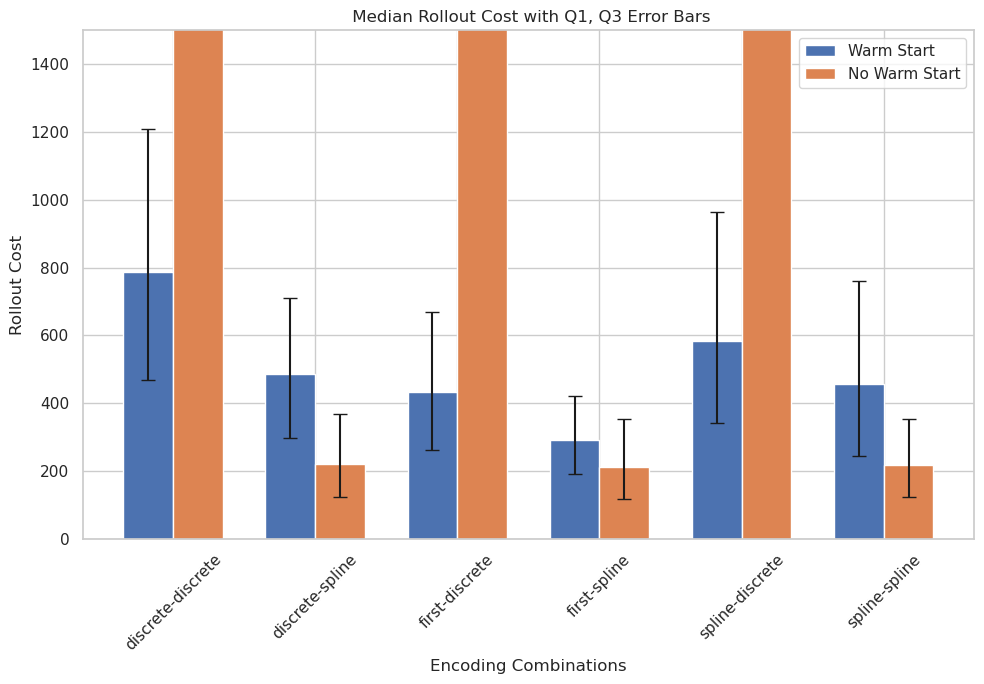

In [183]:
import matplotlib.pyplot as plt
import numpy as np

encoding_combinations = df.index.droplevel('warm_start').unique()
warm_starts = ['-', 'no_warm_start']

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.35
index = np.arange(len(encoding_combinations))

medians, medians_nws = [], []
errors, errors_nws = [], []
for i in index :
    med     = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost']
    med_nws = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost']
    q1      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q1']
    q1_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q1']
    q3      = df.loc['-',             encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q3']
    q3_nws  = df.loc['no_warm_start', encoding_combinations[i][0], encoding_combinations[i][1]]['Sampling_Cost_q3']

    medians.append(med)
    medians_nws.append(med_nws)
    errors.append([med - q1, q3 - med])
    errors_nws.append((med_nws - q1_nws, q3_nws - med_nws))

ax.bar(index          ,medians    , bar_width, yerr=np.array(errors).transpose()    ,label='Warm Start', capsize=5)
ax.bar(index+bar_width,medians_nws, bar_width, yerr=np.array(errors_nws).transpose(),label='No Warm Start', capsize=5)


# Labels and title
ax.set_xlabel('Encoding Combinations')
ax.set_ylabel('Rollout Cost')
ax.set_title(' Median Rollout Cost with Q1, Q3 Error Bars')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{p}-{f}' for p, f in encoding_combinations], rotation=45)
ax.legend(loc='upper right')
ax.set_ylim(0,1500)

# Layout and save as PDF
fig.tight_layout()
# plt.savefig('bar_plot_with_median_q1_q3.pdf')
plt.show()


# 1. Effect of Horizon on sampling Controller

,Reward,Sampling Cost,initial Cost
first-spline-H5-dt02-20,0.023493,72.871353,16.251795
first-spline-H5-dt04-20,0.023491,165.535080,24.996867
first-spline-H10-dt02-20,0.023464,307.234955,32.373672
first-discrete-H5-dt04-20,0.023410,228.196838,31.559715
first-discrete-H10-dt02-20,0.023371,460.497406,37.526196
first-discrete-H5-dt02-20,0.023371,134.921173,30.099570
first-spline-H15-dt02-20,0.023297,1460.406738,76.972092
first-spline-H10-dt04-20,0.023214,2786.325439,133.350708
first-discrete-H10-dt04-20,0.023157,2809.803955,132.624458
first-discrete-H15-dt02-20,0.023137,2124.263184,90.793617


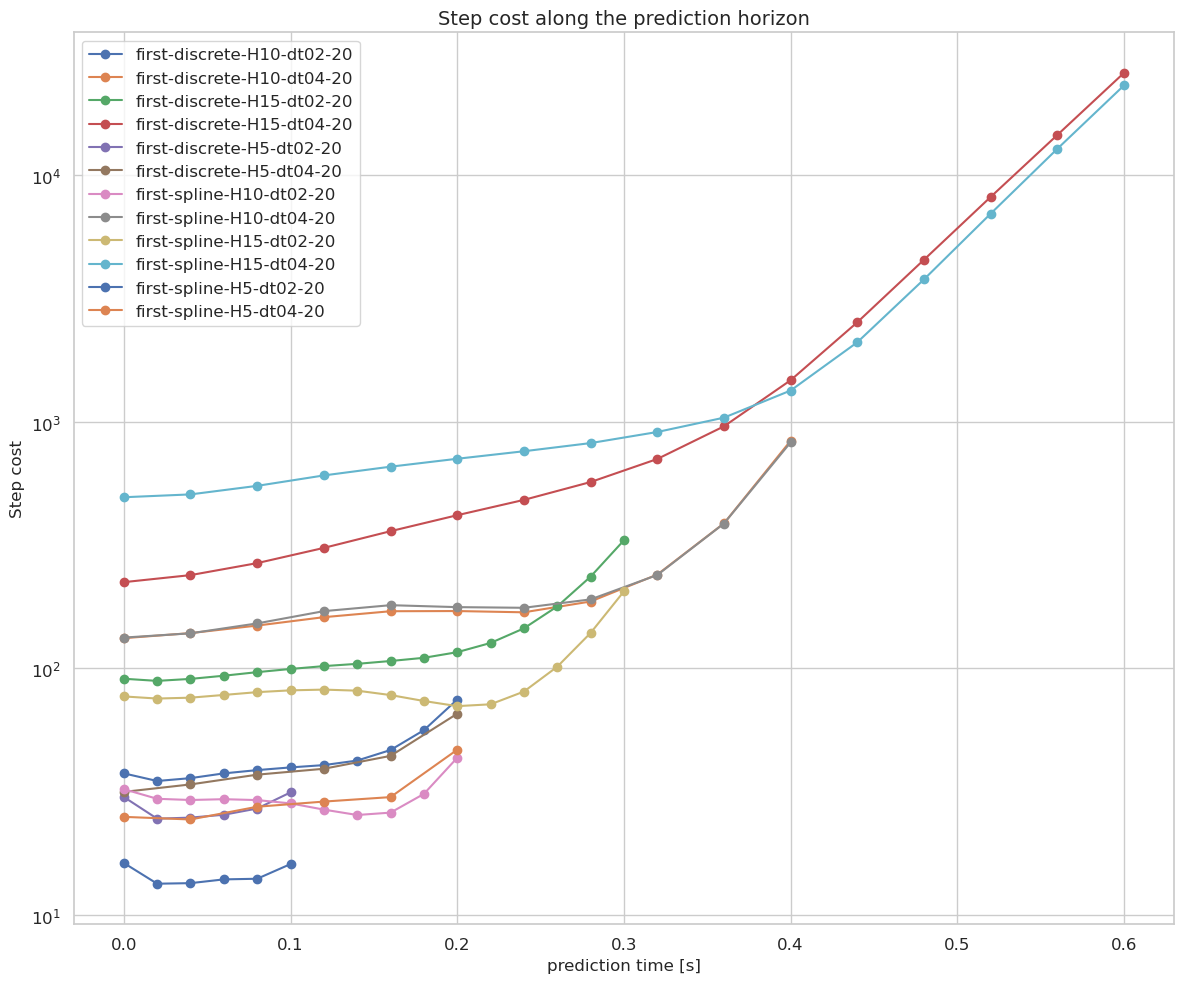

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import torch
import pandas

sns.set_theme(style=style_theme)
plt.figure(figsize=(12, 10))


path_with_opt  = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/samplingController_base_IL_dt02_Force_opti_first_spline_and_dis"
path_with_opt2 = "/home/iit.local/bsavioz/Documents/dls_orbit_bat_private/eval/samplingController_base_IL_dt04_Force_opti_first_spline_and_dis"

info_dict_with_opt = {}
json_info_path_with_opt = os.path.join(path_with_opt, "info.json")
json_info_path_with_opt2= os.path.join(path_with_opt2, "info.json")
if os.path.isfile(json_info_path_with_opt):
    with open(json_info_path_with_opt, 'r') as json_file:
        info_dict_with_opt = json.load(json_file)  
if os.path.isfile(json_info_path_with_opt2):
    with open(json_info_path_with_opt2, 'r') as json_file:
        info_dict_with_opt2 = json.load(json_file)  

info_dict_with_opt = {**info_dict_with_opt, **info_dict_with_opt2}

# key_list = ['first-discrete-H5-dt02-20', 'first-spline-H5-dt02-20', 'first-discrete-H10-dt02-20', 'first-spline-H10-dt02-20', 'first-discrete-H15-dt02-20', 'first-spline-H15-dt02-20']
# index_list = ['H05 - first-discrete', 'H05 - first-spline', 'H10 - first-discrete', 'H10 - first-spline', 'H15 - first-discrete', 'H15 - first-spline']

df = pandas.DataFrame(columns=('Reward','Sampling Cost', 'initial Cost'))

for key in sorted(info_dict_with_opt) : 
# for key in key_list : 
# for i in range(len(key_list)):    
    # key = key_list[i]
    reward = info_dict_with_opt[key]['rewards_median_all']
    sampling_cost = info_dict_with_opt[key]['sampling_cost_median_all']
    init_state = np.median(info_dict_with_opt[key]['step_cost_results']['initial_cost_median'][0])
    q1_init_state = info_dict_with_opt[key]['step_cost_results']['initial_costq1_values']
    q3_init_state = info_dict_with_opt[key]['step_cost_results']['initial_costq3_values']
    y = np.array(info_dict_with_opt[key]['step_cost_results']['step_cost_median'])
    q1 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq1_values'])
    q3 = np.array(info_dict_with_opt[key]['step_cost_results']['step_costq3_values'])
    y= np.insert(y,0,init_state)
    q1 = np.insert(q1,0,q1_init_state)
    q3 = np.insert(q3,0,q3_init_state)
    yerr = [y - q1, q3 - y]

    if '02' in key: x = torch.arange(len(y))*0.02 #+ 0.02
    else :          x = torch.arange(len(y))*0.04 #+ 0.04

    plt.plot(x,y, marker='o', label=key)
    # plt.plot(x,y, marker='o', label=index_list[i])
    # plt.errorbar(x, y, yerr=yerr, marker='o', label=key, capsize=5)

    # print(key, ' - init_state :',init_state,' - Reward :', reward, ' - sampling cost :', sampling_cost)
    df.loc[key] = [reward, sampling_cost, init_state]



# Customize the plot for the scientific report
plt.title('Step cost along the prediction horizon', fontsize=14)
plt.xlabel('prediction time [s]', fontsize=12)
plt.ylabel('Step cost', fontsize=12)
# plt.legend(title=r'Algorithm', fontsize=12, title_fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()

display(df.sort_values(by='Reward',ascending=False))

# Save the plot if needed
# plt.savefig("thesis image/9/DaggervsNaiveMSE.pdf", bbox_inches='tight')

# Show the plot
plt.show()